In [1]:
%matplotlib widget
%matplotlib inline
import torch
import torch.nn as nn
import pickle
import time
import copy
import os
from queue import LifoQueue
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.tree import DecisionTreeClassifier
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances
import network.cpc
from network.cpc import CDCK2
from utils.MatplotlibUtils import reduce_dims_and_plot
from utils.ClassificationUtiols import onehot_coding
from soft_decision_tree.sdt_model import SDT
from sklearn import tree as tt

# IPython.OutputArea.auto_scroll_threshold = 9999;

# Load the model and the dataset

In [2]:
model_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_16/models/epoch_28.pt'
dataset_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_16/data/test_data.file'

print(f"Load the model from: {model_path}")
model = torch.load(model_path, map_location='cpu')

with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)

all_sensors = dataset.dataset.all_signals    
print(f"sensor names: ({len(all_sensors)} total)")

for s in all_sensors:
    print(f"- {s}")
    
print(f"Multihorizon size of the model: {model.timestep}")
print(f"Test split ratio: {len(dataset) / len(dataset.dataset)}")
print(f"Total number of windows in the dataset (without splitting): {len(dataset.dataset)}")

Load the model from: /home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_16/models/epoch_28.pt
sensor names: (18 total)
- speed
- steering_angle
- wheel_speed_0
- wheel_speed_1
- wheel_speed_2
- wheel_speed_3
- accelerometer_0
- accelerometer_1
- accelerometer_2
- gyro_0
- gyro_1
- gyro_2
- gyro_bias_0
- gyro_bias_1
- gyro_bias_2
- gyro_uncalibrated_0
- gyro_uncalibrated_1
- gyro_uncalibrated_2
Multihorizon size of the model: 30
Test split ratio: 0.2
Total number of windows in the dataset (without splitting): 101465


In [3]:
batch_size = 500
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Extract representations

In [4]:
projections = torch.tensor([])
samples = torch.tensor([])
device = 'cuda'
model = model.to(device).eval()

with torch.no_grad():
    bar = tqdm(total=len(loader.dataset))
    for batch in loader:
        hidden = CDCK2.init_hidden(len(batch))
        batch = batch.to(device)
        hidden = hidden.to(device)

        y = model.predict(batch, hidden).detach().cpu()
        projections = torch.cat([projections, y.detach().cpu()])
        samples = torch.cat([samples, batch.detach().cpu()])
        bar.update(y.shape[0])

# Fit GMM and calculate indices

In [5]:
scores = []
best_score = float('inf')
clusters = None
range_ = list(range(5, 80))
for k in tqdm(range_):
    y = GaussianMixture(n_components=k).fit_predict(projections)
    cur_score = davies_bouldin_score(projections, y)
    scores.append(cur_score)
    
    if cur_score < best_score:
        best_score = cur_score
        clusters = y

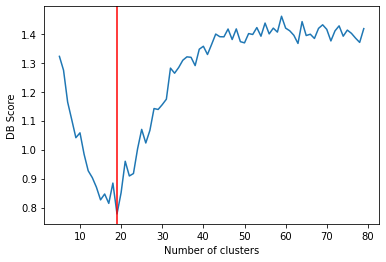

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}


In [6]:
plt.figure()
plt.xlabel('Number of clusters')
plt.ylabel('DB Score')
plt.plot(range_, scores)
best_k = range_[np.argmin(scores)]
plt.axvline(best_k, color='r')
plt.show()

labels = set(clusters)
print(labels)

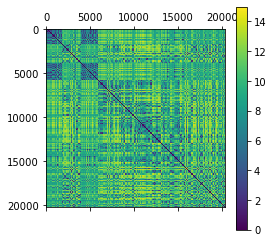

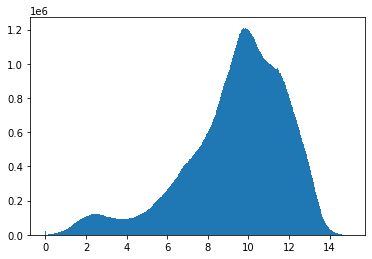

In [7]:
distances = pairwise_distances(projections)
# distances = np.triu(distances)
distances_f = distances.flatten()

plt.matshow(distances)
plt.colorbar()
plt.figure()
plt.hist(distances_f[distances_f > 0], bins=1000)
plt.show()

# Visualize with T-SNE

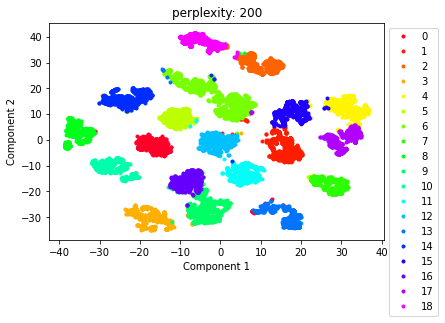

In [8]:
perplexity = 200

p = reduce_dims_and_plot(projections,
                         y=clusters,
                         title=f'perplexity: {perplexity}',
                         file_name=None,
                         perplexity=perplexity,
                         library='Multicore-TSNE',
                         perform_PCA=False,
                         projected=None,
                         figure_type='2d',
                         show_figure=True,
                         close_figure=False,
                         text=None)    

# Train a Soft-Decision-Tree given the self-labels

## Prepare the dataset

In [9]:
# unnormalized_samples = samples.clone()

# for col, sensor in enumerate(tqdm(dataset.dataset.all_signals)):
#     denormalizer = dataset.dataset.get_denormalization_for_sensor(sensor)
#     unnormalized_samples[:, col, :] = denormalizer(unnormalized_samples[:, col, :])

sampled = samples[..., range(0, samples.shape[-1], 200)]

samples_f = sampled.flatten(1)
tree_dataset = list(zip(samples_f, clusters))
batch_size = 2000
tree_loader = torch.utils.data.DataLoader(tree_dataset, batch_size=batch_size, shuffle=True)

# Define how we prune the weights of a node

In [10]:
def prune_node(node_weights, factor=1):
    w = node_weights.cpu().detach().numpy()
    mean_ = np.mean(w)
    std_ = np.std(w)
    node_weights[((mean_ - std_ * factor) < node_weights) & (node_weights < (mean_ + std_ * factor))] = 0
    return node_weights

def prune_node_keep(node_weights, keep=4):
    w = node_weights.cpu().detach().numpy()
    throw_idx = np.argsort(abs(w))[:-keep]
    node_weights[throw_idx] = 0
    return node_weights

def prune_tree(tree_, factor):
    new_weights = tree_.inner_nodes.weight.clone()
    for i in range(new_weights.shape[0]):
        res = prune_node_keep(new_weights[i, :], factor)
        new_weights[i, :] = res

    with torch.no_grad():
        tree_.inner_nodes.weight.copy_(new_weights)
        
def sparseness(x):
    s = []
    for i in range(x.shape[0]):
        x_ = x[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        s.append(sp)
    return np.mean(s)

def compute_regularization_by_level(tree):
    total_reg = 0
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_level = np.floor(np.log2(i+1))
        node_reg = torch.norm(tree.inner_nodes.weight[i].view(-1), 2)
        total_reg += 2**(-cur_level) * node_reg
    return total_reg

def show_sparseness(tree):
    avg_sp = sparseness(tree.inner_nodes.weight)
    print(f"Average sparseness: {avg_sp}")
    layer = 0
    sps = []
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_layer = int(np.floor(np.log2(i+1)))
        if cur_layer != layer:
            print(f"layer {layer}: {np.mean(sps)}")
            sps = []
            layer = cur_layer

        x_ = tree.inner_nodes.weight[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        sps.append(sp)
        
    return avg_sp

## Training configurations

In [11]:
def do_epoch(model, loader, device, log_interval, losses, accs, epoch, iteration):
    model = model.train()
    for batch_idx, (data, target) in enumerate(loader):
        iteration += 1
        data, target = data.to(device), target.to(device)

        output, penalty = tree.forward(data)

        # Loss
        loss_tree = criterion(output, target.view(-1))

        # Penalty
        loss_tree += penalty

        # Sparse regularization
#         fc_params = torch.cat([x.view(-1) for x in tree.inner_nodes.parameters()])
#         regularization = sparsity_lamda * torch.norm(fc_params, 2)
        regularization = sparsity_lamda * compute_regularization_by_level(tree)
        loss = loss_tree

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        pred = output.data.max(1)[1]
        correct = pred.eq(target.view(-1).data).sum()
        accs.append(correct.item() / data.size()[0])

        # Print training status
        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch:02d} | Batch: {batch_idx:03d} / {len(loader):03d} | Total loss: {loss.item():.3f} | Reg loss: {regularization.item():.3f} | Tree loss: {loss_tree.item():.3f} | Accuracy: {correct.item() / data.size()[0]:03f} | {round((time.time() - start_time) / iteration, 3)} sec/iter")
            
    return iteration


In [12]:
lr = 5e-3
weight_decay = 5e-4
sparsity_lamda = 2e-3
epochs = 500
output_dim = len(set(clusters))
log_interval = 1
tree_depth = 10

In [13]:
tree = SDT(input_dim=samples_f.shape[1], output_dim=len(labels), depth=tree_depth, lamda=1e-3, use_cuda=True)
optimizer = torch.optim.Adam(tree.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
tree = tree.to(device)
clf = DecisionTreeClassifier(max_depth=tree_depth).fit(samples_f, clusters)
print(f"DT accuracy: {clf.score(samples_f, clusters)}")
tree.initialize_from_decision_tree(clf)

DT accuracy: 0.9898979943822993


In [14]:
losses = []
accs = []
sparsity = []

In [16]:
start_time = time.time()
iteration = 0
for epoch in range(epochs):
    # Training
    avg_sp = show_sparseness(tree)
    sparsity.append(avg_sp)
    iteration = do_epoch(tree, tree_loader, device, log_interval, losses, accs, epoch, iteration)
    
    if epoch % 1 == 0:
        prune_tree(tree, factor=5)
        

Average sparseness: 0.30644891257972706
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.9271408839779005
layer 5: 0.9271408839779005
layer 6: 0.7726174033149172
layer 7: 0.5099274861878453
layer 8: 0.2781422651933702
Epoch: 00 | Batch: 000 / 011 | Total loss: 2.955 | Reg loss: 0.019 | Tree loss: 2.955 | Accuracy: 0.054500 | 4.694 sec/iter
Epoch: 00 | Batch: 001 / 011 | Total loss: 2.949 | Reg loss: 0.019 | Tree loss: 2.949 | Accuracy: 0.104500 | 3.002 sec/iter
Epoch: 00 | Batch: 002 / 011 | Total loss: 2.938 | Reg loss: 0.019 | Tree loss: 2.938 | Accuracy: 0.181500 | 2.463 sec/iter
Epoch: 00 | Batch: 003 / 011 | Total loss: 2.931 | Reg loss: 0.018 | Tree loss: 2.931 | Accuracy: 0.135500 | 2.187 sec/iter
Epoch: 00 | Batch: 004 / 011 | Total loss: 2.919 | Reg loss: 0.018 | Tree loss: 2.919 | Accuracy: 0.139000 | 1.995 sec/iter
Epoch: 00 | Batch: 005 / 011 | Total loss: 2.911 | Reg loss: 0.018 | Tree loss: 2.911 | Accu

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 05 | Batch: 000 / 011 | Total loss: 2.901 | Reg loss: 0.016 | Tree loss: 2.901 | Accuracy: 0.222000 | 2.251 sec/iter
Epoch: 05 | Batch: 001 / 011 | Total loss: 2.887 | Reg loss: 0.016 | Tree loss: 2.887 | Accuracy: 0.223000 | 2.234 sec/iter
Epoch: 05 | Batch: 002 / 011 | Total loss: 2.868 | Reg loss: 0.016 | Tree loss: 2.868 | Accuracy: 0.233500 | 2.22 sec/iter
Epoch: 05 | Batch: 003 / 011 | Total loss: 2.851 | Reg loss: 0.016 | Tree loss: 2.851 | Accuracy: 0.227000 | 2.202 sec/iter
Epoch: 05 | Batch: 004 / 011 | Total loss: 2.822 | Reg loss: 0.016 | Tree loss: 2.822 | Accuracy: 0.233500 | 2.188 sec/iter
Epoch: 05 | Batch: 005 / 011 | Total loss: 2.811 | Reg loss: 0.016 | Tree loss: 2.811 | Ac

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 10 | Batch: 000 / 011 | Total loss: 2.774 | Reg loss: 0.017 | Tree loss: 2.774 | Accuracy: 0.173000 | 2.175 sec/iter
Epoch: 10 | Batch: 001 / 011 | Total loss: 2.732 | Reg loss: 0.017 | Tree loss: 2.732 | Accuracy: 0.171500 | 2.167 sec/iter
Epoch: 10 | Batch: 002 / 011 | Total loss: 2.705 | Reg loss: 0.017 | Tree loss: 2.705 | Accuracy: 0.178000 | 2.159 sec/iter
Epoch: 10 | Batch: 003 / 011 | Total loss: 2.656 | Reg loss: 0.018 | Tree loss: 2.656 | Accuracy: 0.196000 | 2.15 sec/iter
Epoch: 10 | Batch: 004 / 011 | Total loss: 2.631 | Reg loss: 0.018 | Tree loss: 2.631 | Accuracy: 0.199000 | 2.141 sec/iter
Epoch: 10 | Batch: 005 / 011 | Total loss: 2.580 | Reg loss: 0.018 | Tree loss: 2.580 | Ac

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 15 | Batch: 000 / 011 | Total loss: 2.567 | Reg loss: 0.020 | Tree loss: 2.567 | Accuracy: 0.216500 | 2.175 sec/iter
Epoch: 15 | Batch: 001 / 011 | Total loss: 2.514 | Reg loss: 0.020 | Tree loss: 2.514 | Accuracy: 0.219000 | 2.169 sec/iter
Epoch: 15 | Batch: 002 / 011 | Total loss: 2.469 | Reg loss: 0.020 | Tree loss: 2.469 | Accuracy: 0.233000 | 2.162 sec/iter
Epoch: 15 | Batch: 003 / 011 | Total loss: 2.431 | Reg loss: 0.020 | Tree loss: 2.431 | Accuracy: 0.237500 | 2.155 sec/iter
Epoch: 15 | Batch: 004 / 011 | Total loss: 2.381 | Reg loss: 0.021 | Tree loss: 2.381 | Accuracy: 0.243000 | 2.149 sec/iter
Epoch: 15 | Batch: 005 / 011 | Total loss: 2.348 | Reg loss: 0.021 | Tree loss: 2.348 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 20 | Batch: 000 / 011 | Total loss: 2.338 | Reg loss: 0.023 | Tree loss: 2.338 | Accuracy: 0.268500 | 2.112 sec/iter
Epoch: 20 | Batch: 001 / 011 | Total loss: 2.294 | Reg loss: 0.023 | Tree loss: 2.294 | Accuracy: 0.271500 | 2.108 sec/iter
Epoch: 20 | Batch: 002 / 011 | Total loss: 2.271 | Reg loss: 0.023 | Tree loss: 2.271 | Accuracy: 0.266500 | 2.105 sec/iter
Epoch: 20 | Batch: 003 / 011 | Total loss: 2.223 | Reg loss: 0.023 | Tree loss: 2.223 | Accuracy: 0.300500 | 2.102 sec/iter
Epoch: 20 | Batch: 004 / 011 | Total loss: 2.189 | Reg loss: 0.023 | Tree loss: 2.189 | Accuracy: 0.294000 | 2.1 sec/iter
Epoch: 20 | Batch: 005 / 011 | Total loss: 2.147 | Reg loss: 0.023 | Tree loss: 2.147 | Acc

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 25 | Batch: 000 / 011 | Total loss: 2.164 | Reg loss: 0.025 | Tree loss: 2.164 | Accuracy: 0.308000 | 2.087 sec/iter
Epoch: 25 | Batch: 001 / 011 | Total loss: 2.138 | Reg loss: 0.025 | Tree loss: 2.138 | Accuracy: 0.303500 | 2.083 sec/iter
Epoch: 25 | Batch: 002 / 011 | Total loss: 2.099 | Reg loss: 0.025 | Tree loss: 2.099 | Accuracy: 0.342000 | 2.08 sec/iter
Epoch: 25 | Batch: 003 / 011 | Total loss: 2.062 | Reg loss: 0.025 | Tree loss: 2.062 | Accuracy: 0.352500 | 2.077 sec/iter
Epoch: 25 | Batch: 004 / 011 | Total loss: 2.023 | Reg loss: 0.025 | Tree loss: 2.023 | Accuracy: 0.379500 | 2.073 sec/iter
Epoch: 25 | Batch: 005 / 011 | Total loss: 1.988 | Reg loss: 0.025 | Tree loss: 1.988 | Ac

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 30 | Batch: 000 / 011 | Total loss: 2.030 | Reg loss: 0.026 | Tree loss: 2.030 | Accuracy: 0.365000 | 2.103 sec/iter
Epoch: 30 | Batch: 001 / 011 | Total loss: 1.987 | Reg loss: 0.026 | Tree loss: 1.987 | Accuracy: 0.373000 | 2.1 sec/iter
Epoch: 30 | Batch: 002 / 011 | Total loss: 1.979 | Reg loss: 0.026 | Tree loss: 1.979 | Accuracy: 0.370000 | 2.097 sec/iter
Epoch: 30 | Batch: 003 / 011 | Total loss: 1.912 | Reg loss: 0.026 | Tree loss: 1.912 | Accuracy: 0.405000 | 2.094 sec/iter
Epoch: 30 | Batch: 004 / 011 | Total loss: 1.906 | Reg loss: 0.026 | Tree loss: 1.906 | Accuracy: 0.414000 | 2.091 sec/iter
Epoch: 30 | Batch: 005 / 011 | Total loss: 1.873 | Reg loss: 0.026 | Tree loss: 1.873 | Acc

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 35 | Batch: 000 / 011 | Total loss: 1.962 | Reg loss: 0.028 | Tree loss: 1.962 | Accuracy: 0.362000 | 2.115 sec/iter
Epoch: 35 | Batch: 001 / 011 | Total loss: 1.910 | Reg loss: 0.028 | Tree loss: 1.910 | Accuracy: 0.388500 | 2.112 sec/iter
Epoch: 35 | Batch: 002 / 011 | Total loss: 1.905 | Reg loss: 0.028 | Tree loss: 1.905 | Accuracy: 0.386500 | 2.11 sec/iter
Epoch: 35 | Batch: 003 / 011 | Total loss: 1.871 | Reg loss: 0.028 | Tree loss: 1.871 | Accuracy: 0.388000 | 2.107 sec/iter
Epoch: 35 | Batch: 004 / 011 | Total loss: 1.817 | Reg loss: 0.028 | Tree loss: 1.817 | Accuracy: 0.397500 | 2.104 sec/iter
Epoch: 35 | Batch: 005 / 011 | Total loss: 1.770 | Reg loss: 0.028 | Tree loss: 1.770 | Ac

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 40 | Batch: 000 / 011 | Total loss: 1.892 | Reg loss: 0.029 | Tree loss: 1.892 | Accuracy: 0.375500 | 2.093 sec/iter
Epoch: 40 | Batch: 001 / 011 | Total loss: 1.874 | Reg loss: 0.029 | Tree loss: 1.874 | Accuracy: 0.395500 | 2.091 sec/iter
Epoch: 40 | Batch: 002 / 011 | Total loss: 1.824 | Reg loss: 0.029 | Tree loss: 1.824 | Accuracy: 0.403000 | 2.088 sec/iter
Epoch: 40 | Batch: 003 / 011 | Total loss: 1.806 | Reg loss: 0.029 | Tree loss: 1.806 | Accuracy: 0.403000 | 2.086 sec/iter
Epoch: 40 | Batch: 004 / 011 | Total loss: 1.733 | Reg loss: 0.029 | Tree loss: 1.733 | Accuracy: 0.443500 | 2.084 sec/iter
Epoch: 40 | Batch: 005 / 011 | Total loss: 1.703 | Reg loss: 0.029 | Tree loss: 1.703 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 45 | Batch: 000 / 011 | Total loss: 1.857 | Reg loss: 0.029 | Tree loss: 1.857 | Accuracy: 0.370500 | 2.07 sec/iter
Epoch: 45 | Batch: 001 / 011 | Total loss: 1.825 | Reg loss: 0.029 | Tree loss: 1.825 | Accuracy: 0.395000 | 2.068 sec/iter
Epoch: 45 | Batch: 002 / 011 | Total loss: 1.804 | Reg loss: 0.030 | Tree loss: 1.804 | Accuracy: 0.395500 | 2.067 sec/iter
Epoch: 45 | Batch: 003 / 011 | Total loss: 1.750 | Reg loss: 0.030 | Tree loss: 1.750 | Accuracy: 0.417000 | 2.066 sec/iter
Epoch: 45 | Batch: 004 / 011 | Total loss: 1.698 | Reg loss: 0.030 | Tree loss: 1.698 | Accuracy: 0.446500 | 2.064 sec/iter
Epoch: 45 | Batch: 005 / 011 | Total loss: 1.676 | Reg loss: 0.030 | Tree loss: 1.676 | Ac

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 50 | Batch: 000 / 011 | Total loss: 1.833 | Reg loss: 0.030 | Tree loss: 1.833 | Accuracy: 0.371000 | 2.036 sec/iter
Epoch: 50 | Batch: 001 / 011 | Total loss: 1.791 | Reg loss: 0.030 | Tree loss: 1.791 | Accuracy: 0.393500 | 2.035 sec/iter
Epoch: 50 | Batch: 002 / 011 | Total loss: 1.761 | Reg loss: 0.030 | Tree loss: 1.761 | Accuracy: 0.419500 | 2.033 sec/iter
Epoch: 50 | Batch: 003 / 011 | Total loss: 1.721 | Reg loss: 0.030 | Tree loss: 1.721 | Accuracy: 0.419000 | 2.032 sec/iter
Epoch: 50 | Batch: 004 / 011 | Total loss: 1.681 | Reg loss: 0.030 | Tree loss: 1.681 | Accuracy: 0.455000 | 2.031 sec/iter
Epoch: 50 | Batch: 005 / 011 | Total loss: 1.650 | Reg loss: 0.030 | Tree loss: 1.650 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 55 | Batch: 000 / 011 | Total loss: 1.831 | Reg loss: 0.030 | Tree loss: 1.831 | Accuracy: 0.362500 | 2.014 sec/iter
Epoch: 55 | Batch: 001 / 011 | Total loss: 1.762 | Reg loss: 0.031 | Tree loss: 1.762 | Accuracy: 0.404500 | 2.013 sec/iter
Epoch: 55 | Batch: 002 / 011 | Total loss: 1.732 | Reg loss: 0.031 | Tree loss: 1.732 | Accuracy: 0.410500 | 2.011 sec/iter
Epoch: 55 | Batch: 003 / 011 | Total loss: 1.684 | Reg loss: 0.031 | Tree loss: 1.684 | Accuracy: 0.453000 | 2.01 sec/iter
Epoch: 55 | Batch: 004 / 011 | Total loss: 1.654 | Reg loss: 0.031 | Tree loss: 1.654 | Accuracy: 0.450000 | 2.008 sec/iter
Epoch: 55 | Batch: 005 / 011 | Total loss: 1.633 | Reg loss: 0.031 | Tree loss: 1.633 | Ac

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 60 | Batch: 000 / 011 | Total loss: 1.802 | Reg loss: 0.031 | Tree loss: 1.802 | Accuracy: 0.380500 | 2.008 sec/iter
Epoch: 60 | Batch: 001 / 011 | Total loss: 1.758 | Reg loss: 0.031 | Tree loss: 1.758 | Accuracy: 0.369000 | 2.006 sec/iter
Epoch: 60 | Batch: 002 / 011 | Total loss: 1.717 | Reg loss: 0.031 | Tree loss: 1.717 | Accuracy: 0.411500 | 2.005 sec/iter
Epoch: 60 | Batch: 003 / 011 | Total loss: 1.699 | Reg loss: 0.031 | Tree loss: 1.699 | Accuracy: 0.426000 | 2.003 sec/iter
Epoch: 60 | Batch: 004 / 011 | Total loss: 1.636 | Reg loss: 0.031 | Tree loss: 1.636 | Accuracy: 0.450500 | 2.001 sec/iter
Epoch: 60 | Batch: 005 / 011 | Total loss: 1.606 | Reg loss: 0.031 | Tree loss: 1.606 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 65 | Batch: 000 / 011 | Total loss: 1.762 | Reg loss: 0.031 | Tree loss: 1.762 | Accuracy: 0.387500 | 2.008 sec/iter
Epoch: 65 | Batch: 001 / 011 | Total loss: 1.750 | Reg loss: 0.031 | Tree loss: 1.750 | Accuracy: 0.393500 | 2.006 sec/iter
Epoch: 65 | Batch: 002 / 011 | Total loss: 1.708 | Reg loss: 0.031 | Tree loss: 1.708 | Accuracy: 0.436500 | 2.005 sec/iter
Epoch: 65 | Batch: 003 / 011 | Total loss: 1.685 | Reg loss: 0.031 | Tree loss: 1.685 | Accuracy: 0.426000 | 2.004 sec/iter
Epoch: 65 | Batch: 004 / 011 | Total loss: 1.638 | Reg loss: 0.031 | Tree loss: 1.638 | Accuracy: 0.436000 | 2.002 sec/iter
Epoch: 65 | Batch: 005 / 011 | Total loss: 1.603 | Reg loss: 0.031 | Tree loss: 1.603 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 70 | Batch: 000 / 011 | Total loss: 1.754 | Reg loss: 0.031 | Tree loss: 1.754 | Accuracy: 0.382000 | 2.003 sec/iter
Epoch: 70 | Batch: 001 / 011 | Total loss: 1.735 | Reg loss: 0.031 | Tree loss: 1.735 | Accuracy: 0.400000 | 2.002 sec/iter
Epoch: 70 | Batch: 002 / 011 | Total loss: 1.719 | Reg loss: 0.031 | Tree loss: 1.719 | Accuracy: 0.409500 | 2.001 sec/iter
Epoch: 70 | Batch: 003 / 011 | Total loss: 1.656 | Reg loss: 0.031 | Tree loss: 1.656 | Accuracy: 0.448000 | 2.0 sec/iter
Epoch: 70 | Batch: 004 / 011 | Total loss: 1.598 | Reg loss: 0.031 | Tree loss: 1.598 | Accuracy: 0.444500 | 1.999 sec/iter
Epoch: 70 | Batch: 005 / 011 | Total loss: 1.588 | Reg loss: 0.031 | Tree loss: 1.588 | Acc

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 75 | Batch: 000 / 011 | Total loss: 1.747 | Reg loss: 0.031 | Tree loss: 1.747 | Accuracy: 0.382500 | 1.978 sec/iter
Epoch: 75 | Batch: 001 / 011 | Total loss: 1.712 | Reg loss: 0.031 | Tree loss: 1.712 | Accuracy: 0.403000 | 1.977 sec/iter
Epoch: 75 | Batch: 002 / 011 | Total loss: 1.680 | Reg loss: 0.031 | Tree loss: 1.680 | Accuracy: 0.419500 | 1.976 sec/iter
Epoch: 75 | Batch: 003 / 011 | Total loss: 1.633 | Reg loss: 0.031 | Tree loss: 1.633 | Accuracy: 0.438500 | 1.975 sec/iter
Epoch: 75 | Batch: 004 / 011 | Total loss: 1.610 | Reg loss: 0.031 | Tree loss: 1.610 | Accuracy: 0.431000 | 1.975 sec/iter
Epoch: 75 | Batch: 005 / 011 | Total loss: 1.573 | Reg loss: 0.031 | Tree loss: 1.573 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 80 | Batch: 000 / 011 | Total loss: 1.714 | Reg loss: 0.031 | Tree loss: 1.714 | Accuracy: 0.400000 | 1.965 sec/iter
Epoch: 80 | Batch: 001 / 011 | Total loss: 1.739 | Reg loss: 0.031 | Tree loss: 1.739 | Accuracy: 0.389000 | 1.964 sec/iter
Epoch: 80 | Batch: 002 / 011 | Total loss: 1.659 | Reg loss: 0.031 | Tree loss: 1.659 | Accuracy: 0.436000 | 1.963 sec/iter
Epoch: 80 | Batch: 003 / 011 | Total loss: 1.649 | Reg loss: 0.031 | Tree loss: 1.649 | Accuracy: 0.426000 | 1.962 sec/iter
Epoch: 80 | Batch: 004 / 011 | Total loss: 1.577 | Reg loss: 0.031 | Tree loss: 1.577 | Accuracy: 0.451500 | 1.961 sec/iter
Epoch: 80 | Batch: 005 / 011 | Total loss: 1.567 | Reg loss: 0.031 | Tree loss: 1.567 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 85 | Batch: 000 / 011 | Total loss: 1.705 | Reg loss: 0.031 | Tree loss: 1.705 | Accuracy: 0.411500 | 1.967 sec/iter
Epoch: 85 | Batch: 001 / 011 | Total loss: 1.710 | Reg loss: 0.031 | Tree loss: 1.710 | Accuracy: 0.409000 | 1.966 sec/iter
Epoch: 85 | Batch: 002 / 011 | Total loss: 1.658 | Reg loss: 0.031 | Tree loss: 1.658 | Accuracy: 0.415000 | 1.965 sec/iter
Epoch: 85 | Batch: 003 / 011 | Total loss: 1.635 | Reg loss: 0.031 | Tree loss: 1.635 | Accuracy: 0.428500 | 1.964 sec/iter
Epoch: 85 | Batch: 004 / 011 | Total loss: 1.588 | Reg loss: 0.031 | Tree loss: 1.588 | Accuracy: 0.456500 | 1.963 sec/iter
Epoch: 85 | Batch: 005 / 011 | Total loss: 1.562 | Reg loss: 0.031 | Tree loss: 1.562 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 90 | Batch: 000 / 011 | Total loss: 1.704 | Reg loss: 0.031 | Tree loss: 1.704 | Accuracy: 0.416500 | 1.977 sec/iter
Epoch: 90 | Batch: 001 / 011 | Total loss: 1.687 | Reg loss: 0.031 | Tree loss: 1.687 | Accuracy: 0.402000 | 1.976 sec/iter
Epoch: 90 | Batch: 002 / 011 | Total loss: 1.632 | Reg loss: 0.031 | Tree loss: 1.632 | Accuracy: 0.422500 | 1.975 sec/iter
Epoch: 90 | Batch: 003 / 011 | Total loss: 1.630 | Reg loss: 0.031 | Tree loss: 1.630 | Accuracy: 0.446500 | 1.974 sec/iter
Epoch: 90 | Batch: 004 / 011 | Total loss: 1.589 | Reg loss: 0.031 | Tree loss: 1.589 | Accuracy: 0.428000 | 1.973 sec/iter
Epoch: 90 | Batch: 005 / 011 | Total loss: 1.563 | Reg loss: 0.031 | Tree loss: 1.563 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 95 | Batch: 000 / 011 | Total loss: 1.726 | Reg loss: 0.031 | Tree loss: 1.726 | Accuracy: 0.393000 | 1.978 sec/iter
Epoch: 95 | Batch: 001 / 011 | Total loss: 1.670 | Reg loss: 0.031 | Tree loss: 1.670 | Accuracy: 0.414500 | 1.977 sec/iter
Epoch: 95 | Batch: 002 / 011 | Total loss: 1.659 | Reg loss: 0.031 | Tree loss: 1.659 | Accuracy: 0.410500 | 1.976 sec/iter
Epoch: 95 | Batch: 003 / 011 | Total loss: 1.613 | Reg loss: 0.031 | Tree loss: 1.613 | Accuracy: 0.443500 | 1.976 sec/iter
Epoch: 95 | Batch: 004 / 011 | Total loss: 1.561 | Reg loss: 0.031 | Tree loss: 1.561 | Accuracy: 0.452500 | 1.975 sec/iter
Epoch: 95 | Batch: 005 / 011 | Total loss: 1.552 | Reg loss: 0.031 | Tree loss: 1.552 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 100 | Batch: 000 / 011 | Total loss: 1.714 | Reg loss: 0.032 | Tree loss: 1.714 | Accuracy: 0.406500 | 1.97 sec/iter
Epoch: 100 | Batch: 001 / 011 | Total loss: 1.673 | Reg loss: 0.032 | Tree loss: 1.673 | Accuracy: 0.422500 | 1.97 sec/iter
Epoch: 100 | Batch: 002 / 011 | Total loss: 1.668 | Reg loss: 0.032 | Tree loss: 1.668 | Accuracy: 0.432500 | 1.969 sec/iter
Epoch: 100 | Batch: 003 / 011 | Total loss: 1.585 | Reg loss: 0.032 | Tree loss: 1.585 | Accuracy: 0.443500 | 1.969 sec/iter
Epoch: 100 | Batch: 004 / 011 | Total loss: 1.571 | Reg loss: 0.032 | Tree loss: 1.571 | Accuracy: 0.447000 | 1.968 sec/iter
Epoch: 100 | Batch: 005 / 011 | Total loss: 1.546 | Reg loss: 0.032 | Tree loss: 1.546

Epoch: 104 | Batch: 010 / 011 | Total loss: 1.532 | Reg loss: 0.032 | Tree loss: 1.532 | Accuracy: 0.423208 | 1.96 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 105 | Batch: 000 / 011 | Total loss: 1.726 | Reg loss: 0.032 | Tree loss: 1.726 | Accuracy: 0.397000 | 1.968 sec/iter
Epoch: 105 | Batch: 001 / 011 | Total loss: 1.670 | Reg loss: 0.032 | Tree loss: 1.670 | Accuracy: 0.405500 | 1.967 sec/iter
Epoch: 105 | Batch: 002 / 011 | Total loss: 1.629 | Reg loss: 0.032 | Tree loss: 1.629 | Accuracy: 0.429500 | 1.966 sec/iter
Epoch: 105 | Batch: 003 / 011 | Total loss: 1.601 | Reg loss: 0.032 | Tree loss: 1.601 | Accuracy: 0.453500 | 1.966 sec/iter
Epoch: 105 | Batch: 004 / 011 | Total loss: 1.565 | Reg loss: 0.032 | Tree loss: 1.56

Epoch: 109 | Batch: 009 / 011 | Total loss: 1.479 | Reg loss: 0.032 | Tree loss: 1.479 | Accuracy: 0.460000 | 1.958 sec/iter
Epoch: 109 | Batch: 010 / 011 | Total loss: 1.527 | Reg loss: 0.032 | Tree loss: 1.527 | Accuracy: 0.443686 | 1.957 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 110 | Batch: 000 / 011 | Total loss: 1.680 | Reg loss: 0.032 | Tree loss: 1.680 | Accuracy: 0.412000 | 1.967 sec/iter
Epoch: 110 | Batch: 001 / 011 | Total loss: 1.684 | Reg loss: 0.032 | Tree loss: 1.684 | Accuracy: 0.416500 | 1.967 sec/iter
Epoch: 110 | Batch: 002 / 011 | Total loss: 1.635 | Reg loss: 0.032 | Tree loss: 1.635 | Accuracy: 0.429500 | 1.966 sec/iter
Epoch: 110 | Batch: 003 / 011 | Total loss: 1.618 | Reg loss: 0.032 | Tree loss: 1.6

Epoch: 114 | Batch: 008 / 011 | Total loss: 1.473 | Reg loss: 0.032 | Tree loss: 1.473 | Accuracy: 0.475000 | 1.966 sec/iter
Epoch: 114 | Batch: 009 / 011 | Total loss: 1.479 | Reg loss: 0.032 | Tree loss: 1.479 | Accuracy: 0.475500 | 1.966 sec/iter
Epoch: 114 | Batch: 010 / 011 | Total loss: 1.465 | Reg loss: 0.032 | Tree loss: 1.465 | Accuracy: 0.484642 | 1.965 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 115 | Batch: 000 / 011 | Total loss: 1.675 | Reg loss: 0.032 | Tree loss: 1.675 | Accuracy: 0.412500 | 1.972 sec/iter
Epoch: 115 | Batch: 001 / 011 | Total loss: 1.668 | Reg loss: 0.032 | Tree loss: 1.668 | Accuracy: 0.415500 | 1.972 sec/iter
Epoch: 115 | Batch: 002 / 011 | Total loss: 1.607 | Reg loss: 0.032 | Tree loss: 1.6

Epoch: 119 | Batch: 007 / 011 | Total loss: 1.481 | Reg loss: 0.032 | Tree loss: 1.481 | Accuracy: 0.480000 | 1.968 sec/iter
Epoch: 119 | Batch: 008 / 011 | Total loss: 1.492 | Reg loss: 0.032 | Tree loss: 1.492 | Accuracy: 0.462500 | 1.967 sec/iter
Epoch: 119 | Batch: 009 / 011 | Total loss: 1.489 | Reg loss: 0.032 | Tree loss: 1.489 | Accuracy: 0.456000 | 1.966 sec/iter
Epoch: 119 | Batch: 010 / 011 | Total loss: 1.479 | Reg loss: 0.032 | Tree loss: 1.479 | Accuracy: 0.501706 | 1.966 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 120 | Batch: 000 / 011 | Total loss: 1.693 | Reg loss: 0.032 | Tree loss: 1.693 | Accuracy: 0.403000 | 1.969 sec/iter
Epoch: 120 | Batch: 001 / 011 | Total loss: 1.640 | Reg loss: 0.032 | Tree loss: 1.6

Epoch: 124 | Batch: 006 / 011 | Total loss: 1.497 | Reg loss: 0.032 | Tree loss: 1.497 | Accuracy: 0.478500 | 1.973 sec/iter
Epoch: 124 | Batch: 007 / 011 | Total loss: 1.487 | Reg loss: 0.032 | Tree loss: 1.487 | Accuracy: 0.460500 | 1.973 sec/iter
Epoch: 124 | Batch: 008 / 011 | Total loss: 1.477 | Reg loss: 0.032 | Tree loss: 1.477 | Accuracy: 0.473000 | 1.972 sec/iter
Epoch: 124 | Batch: 009 / 011 | Total loss: 1.459 | Reg loss: 0.032 | Tree loss: 1.459 | Accuracy: 0.472500 | 1.971 sec/iter
Epoch: 124 | Batch: 010 / 011 | Total loss: 1.431 | Reg loss: 0.032 | Tree loss: 1.431 | Accuracy: 0.484642 | 1.971 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 125 | Batch: 000 / 011 | Total loss: 1.689 | Reg loss: 0.032 | Tree loss: 1.6

Epoch: 129 | Batch: 005 / 011 | Total loss: 1.523 | Reg loss: 0.032 | Tree loss: 1.523 | Accuracy: 0.449500 | 1.971 sec/iter
Epoch: 129 | Batch: 006 / 011 | Total loss: 1.473 | Reg loss: 0.032 | Tree loss: 1.473 | Accuracy: 0.484000 | 1.971 sec/iter
Epoch: 129 | Batch: 007 / 011 | Total loss: 1.477 | Reg loss: 0.032 | Tree loss: 1.477 | Accuracy: 0.465000 | 1.97 sec/iter
Epoch: 129 | Batch: 008 / 011 | Total loss: 1.470 | Reg loss: 0.032 | Tree loss: 1.470 | Accuracy: 0.469500 | 1.97 sec/iter
Epoch: 129 | Batch: 009 / 011 | Total loss: 1.483 | Reg loss: 0.032 | Tree loss: 1.483 | Accuracy: 0.453500 | 1.969 sec/iter
Epoch: 129 | Batch: 010 / 011 | Total loss: 1.476 | Reg loss: 0.032 | Tree loss: 1.476 | Accuracy: 0.470990 | 1.968 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.972375

Epoch: 134 | Batch: 004 / 011 | Total loss: 1.537 | Reg loss: 0.032 | Tree loss: 1.537 | Accuracy: 0.442000 | 1.965 sec/iter
Epoch: 134 | Batch: 005 / 011 | Total loss: 1.492 | Reg loss: 0.032 | Tree loss: 1.492 | Accuracy: 0.463500 | 1.964 sec/iter
Epoch: 134 | Batch: 006 / 011 | Total loss: 1.481 | Reg loss: 0.032 | Tree loss: 1.481 | Accuracy: 0.469500 | 1.964 sec/iter
Epoch: 134 | Batch: 007 / 011 | Total loss: 1.471 | Reg loss: 0.032 | Tree loss: 1.471 | Accuracy: 0.466000 | 1.963 sec/iter
Epoch: 134 | Batch: 008 / 011 | Total loss: 1.486 | Reg loss: 0.032 | Tree loss: 1.486 | Accuracy: 0.460500 | 1.963 sec/iter
Epoch: 134 | Batch: 009 / 011 | Total loss: 1.470 | Reg loss: 0.032 | Tree loss: 1.470 | Accuracy: 0.465500 | 1.962 sec/iter
Epoch: 134 | Batch: 010 / 011 | Total loss: 1.475 | Reg loss: 0.032 | Tree loss: 1.475 | Accuracy: 0.443686 | 1.962 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 139 | Batch: 003 / 011 | Total loss: 1.583 | Reg loss: 0.032 | Tree loss: 1.583 | Accuracy: 0.432000 | 1.965 sec/iter
Epoch: 139 | Batch: 004 / 011 | Total loss: 1.518 | Reg loss: 0.032 | Tree loss: 1.518 | Accuracy: 0.454500 | 1.964 sec/iter
Epoch: 139 | Batch: 005 / 011 | Total loss: 1.506 | Reg loss: 0.032 | Tree loss: 1.506 | Accuracy: 0.468000 | 1.963 sec/iter
Epoch: 139 | Batch: 006 / 011 | Total loss: 1.484 | Reg loss: 0.032 | Tree loss: 1.484 | Accuracy: 0.470500 | 1.963 sec/iter
Epoch: 139 | Batch: 007 / 011 | Total loss: 1.470 | Reg loss: 0.032 | Tree loss: 1.470 | Accuracy: 0.469000 | 1.962 sec/iter
Epoch: 139 | Batch: 008 / 011 | Total loss: 1.462 | Reg loss: 0.032 | Tree loss: 1.462 | Accuracy: 0.479500 | 1.962 sec/iter
Epoch: 139 | Batch: 009 / 011 | Total loss: 1.449 | Reg loss: 0.032 | Tree loss: 1.449 | Accuracy: 0.487500 | 1.962 sec/iter
Epoch: 139 | Batch: 010 / 011 | Total loss: 1.413 | Reg loss: 0.032 | Tree loss: 1.413 | Accuracy: 0.518771 | 1.961 sec/iter


Epoch: 144 | Batch: 002 / 011 | Total loss: 1.586 | Reg loss: 0.032 | Tree loss: 1.586 | Accuracy: 0.450500 | 1.957 sec/iter
Epoch: 144 | Batch: 003 / 011 | Total loss: 1.596 | Reg loss: 0.032 | Tree loss: 1.596 | Accuracy: 0.424500 | 1.956 sec/iter
Epoch: 144 | Batch: 004 / 011 | Total loss: 1.538 | Reg loss: 0.032 | Tree loss: 1.538 | Accuracy: 0.462500 | 1.956 sec/iter
Epoch: 144 | Batch: 005 / 011 | Total loss: 1.510 | Reg loss: 0.032 | Tree loss: 1.510 | Accuracy: 0.470000 | 1.955 sec/iter
Epoch: 144 | Batch: 006 / 011 | Total loss: 1.463 | Reg loss: 0.032 | Tree loss: 1.463 | Accuracy: 0.477500 | 1.954 sec/iter
Epoch: 144 | Batch: 007 / 011 | Total loss: 1.468 | Reg loss: 0.032 | Tree loss: 1.468 | Accuracy: 0.479500 | 1.954 sec/iter
Epoch: 144 | Batch: 008 / 011 | Total loss: 1.452 | Reg loss: 0.032 | Tree loss: 1.452 | Accuracy: 0.487000 | 1.953 sec/iter
Epoch: 144 | Batch: 009 / 011 | Total loss: 1.466 | Reg loss: 0.032 | Tree loss: 1.466 | Accuracy: 0.462000 | 1.953 sec/iter


Epoch: 149 | Batch: 001 / 011 | Total loss: 1.615 | Reg loss: 0.032 | Tree loss: 1.615 | Accuracy: 0.409500 | 1.951 sec/iter
Epoch: 149 | Batch: 002 / 011 | Total loss: 1.590 | Reg loss: 0.032 | Tree loss: 1.590 | Accuracy: 0.424500 | 1.95 sec/iter
Epoch: 149 | Batch: 003 / 011 | Total loss: 1.571 | Reg loss: 0.032 | Tree loss: 1.571 | Accuracy: 0.439000 | 1.95 sec/iter
Epoch: 149 | Batch: 004 / 011 | Total loss: 1.541 | Reg loss: 0.032 | Tree loss: 1.541 | Accuracy: 0.432000 | 1.949 sec/iter
Epoch: 149 | Batch: 005 / 011 | Total loss: 1.495 | Reg loss: 0.032 | Tree loss: 1.495 | Accuracy: 0.455500 | 1.949 sec/iter
Epoch: 149 | Batch: 006 / 011 | Total loss: 1.469 | Reg loss: 0.032 | Tree loss: 1.469 | Accuracy: 0.495000 | 1.948 sec/iter
Epoch: 149 | Batch: 007 / 011 | Total loss: 1.471 | Reg loss: 0.032 | Tree loss: 1.471 | Accuracy: 0.475500 | 1.947 sec/iter
Epoch: 149 | Batch: 008 / 011 | Total loss: 1.470 | Reg loss: 0.032 | Tree loss: 1.470 | Accuracy: 0.463000 | 1.947 sec/iter
Ep

Epoch: 154 | Batch: 000 / 011 | Total loss: 1.686 | Reg loss: 0.032 | Tree loss: 1.686 | Accuracy: 0.385000 | 1.941 sec/iter
Epoch: 154 | Batch: 001 / 011 | Total loss: 1.617 | Reg loss: 0.032 | Tree loss: 1.617 | Accuracy: 0.438500 | 1.941 sec/iter
Epoch: 154 | Batch: 002 / 011 | Total loss: 1.594 | Reg loss: 0.032 | Tree loss: 1.594 | Accuracy: 0.427500 | 1.941 sec/iter
Epoch: 154 | Batch: 003 / 011 | Total loss: 1.544 | Reg loss: 0.032 | Tree loss: 1.544 | Accuracy: 0.449500 | 1.94 sec/iter
Epoch: 154 | Batch: 004 / 011 | Total loss: 1.526 | Reg loss: 0.032 | Tree loss: 1.526 | Accuracy: 0.445500 | 1.94 sec/iter
Epoch: 154 | Batch: 005 / 011 | Total loss: 1.480 | Reg loss: 0.032 | Tree loss: 1.480 | Accuracy: 0.458000 | 1.939 sec/iter
Epoch: 154 | Batch: 006 / 011 | Total loss: 1.479 | Reg loss: 0.032 | Tree loss: 1.479 | Accuracy: 0.485500 | 1.939 sec/iter
Epoch: 154 | Batch: 007 / 011 | Total loss: 1.461 | Reg loss: 0.032 | Tree loss: 1.461 | Accuracy: 0.465000 | 1.939 sec/iter
Ep

layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 159 | Batch: 000 / 011 | Total loss: 1.652 | Reg loss: 0.033 | Tree loss: 1.652 | Accuracy: 0.409000 | 1.94 sec/iter
Epoch: 159 | Batch: 001 / 011 | Total loss: 1.626 | Reg loss: 0.033 | Tree loss: 1.626 | Accuracy: 0.432500 | 1.94 sec/iter
Epoch: 159 | Batch: 002 / 011 | Total loss: 1.586 | Reg loss: 0.033 | Tree loss: 1.586 | Accuracy: 0.430500 | 1.939 sec/iter
Epoch: 159 | Batch: 003 / 011 | Total loss: 1.568 | Reg loss: 0.033 | Tree loss: 1.568 | Accuracy: 0.442000 | 1.939 sec/iter
Epoch: 159 | Batch: 004 / 011 | Total loss: 1.528 | Reg loss: 0.033 | Tree loss: 1.528 | Accuracy: 0.441000 | 1.938 sec/iter
Epoch: 159 | Batch: 005 / 011 | Total loss: 1.491 | Reg loss: 0.033 | Tree loss: 1.491 | Accuracy: 0.465500 | 1.938 sec/iter
Epoch: 159 | Batch: 006 / 011 | Total loss: 1.458 | Reg loss: 0.033 | Tree loss: 1.458 | Accuracy: 0.482000 | 1.938 sec/iter
Epoch: 159 | Ba

layer 8: 0.9723756906077345
Epoch: 164 | Batch: 000 / 011 | Total loss: 1.659 | Reg loss: 0.033 | Tree loss: 1.659 | Accuracy: 0.395500 | 1.929 sec/iter
Epoch: 164 | Batch: 001 / 011 | Total loss: 1.625 | Reg loss: 0.033 | Tree loss: 1.625 | Accuracy: 0.416500 | 1.929 sec/iter
Epoch: 164 | Batch: 002 / 011 | Total loss: 1.593 | Reg loss: 0.033 | Tree loss: 1.593 | Accuracy: 0.438000 | 1.928 sec/iter
Epoch: 164 | Batch: 003 / 011 | Total loss: 1.554 | Reg loss: 0.033 | Tree loss: 1.554 | Accuracy: 0.439500 | 1.928 sec/iter
Epoch: 164 | Batch: 004 / 011 | Total loss: 1.528 | Reg loss: 0.033 | Tree loss: 1.528 | Accuracy: 0.455000 | 1.928 sec/iter
Epoch: 164 | Batch: 005 / 011 | Total loss: 1.492 | Reg loss: 0.033 | Tree loss: 1.492 | Accuracy: 0.474500 | 1.927 sec/iter
Epoch: 164 | Batch: 006 / 011 | Total loss: 1.466 | Reg loss: 0.033 | Tree loss: 1.466 | Accuracy: 0.485500 | 1.927 sec/iter
Epoch: 164 | Batch: 007 / 011 | Total loss: 1.459 | Reg loss: 0.033 | Tree loss: 1.459 | Accuracy

layer 8: 0.9723756906077345
Epoch: 169 | Batch: 000 / 011 | Total loss: 1.656 | Reg loss: 0.033 | Tree loss: 1.656 | Accuracy: 0.411500 | 1.918 sec/iter
Epoch: 169 | Batch: 001 / 011 | Total loss: 1.629 | Reg loss: 0.033 | Tree loss: 1.629 | Accuracy: 0.421500 | 1.917 sec/iter
Epoch: 169 | Batch: 002 / 011 | Total loss: 1.581 | Reg loss: 0.033 | Tree loss: 1.581 | Accuracy: 0.451500 | 1.917 sec/iter
Epoch: 169 | Batch: 003 / 011 | Total loss: 1.546 | Reg loss: 0.033 | Tree loss: 1.546 | Accuracy: 0.461000 | 1.917 sec/iter
Epoch: 169 | Batch: 004 / 011 | Total loss: 1.525 | Reg loss: 0.033 | Tree loss: 1.525 | Accuracy: 0.441500 | 1.916 sec/iter
Epoch: 169 | Batch: 005 / 011 | Total loss: 1.479 | Reg loss: 0.033 | Tree loss: 1.479 | Accuracy: 0.472000 | 1.916 sec/iter
Epoch: 169 | Batch: 006 / 011 | Total loss: 1.471 | Reg loss: 0.033 | Tree loss: 1.471 | Accuracy: 0.473500 | 1.916 sec/iter
Epoch: 169 | Batch: 007 / 011 | Total loss: 1.458 | Reg loss: 0.033 | Tree loss: 1.458 | Accuracy

layer 8: 0.9723756906077345
Epoch: 174 | Batch: 000 / 011 | Total loss: 1.661 | Reg loss: 0.033 | Tree loss: 1.661 | Accuracy: 0.391500 | 1.913 sec/iter
Epoch: 174 | Batch: 001 / 011 | Total loss: 1.621 | Reg loss: 0.033 | Tree loss: 1.621 | Accuracy: 0.419500 | 1.912 sec/iter
Epoch: 174 | Batch: 002 / 011 | Total loss: 1.566 | Reg loss: 0.033 | Tree loss: 1.566 | Accuracy: 0.447500 | 1.912 sec/iter
Epoch: 174 | Batch: 003 / 011 | Total loss: 1.541 | Reg loss: 0.033 | Tree loss: 1.541 | Accuracy: 0.453500 | 1.911 sec/iter
Epoch: 174 | Batch: 004 / 011 | Total loss: 1.513 | Reg loss: 0.033 | Tree loss: 1.513 | Accuracy: 0.462000 | 1.911 sec/iter
Epoch: 174 | Batch: 005 / 011 | Total loss: 1.497 | Reg loss: 0.033 | Tree loss: 1.497 | Accuracy: 0.457500 | 1.91 sec/iter
Epoch: 174 | Batch: 006 / 011 | Total loss: 1.443 | Reg loss: 0.033 | Tree loss: 1.443 | Accuracy: 0.485000 | 1.91 sec/iter
Epoch: 174 | Batch: 007 / 011 | Total loss: 1.424 | Reg loss: 0.033 | Tree loss: 1.424 | Accuracy: 

layer 8: 0.9723756906077345
Epoch: 179 | Batch: 000 / 011 | Total loss: 1.654 | Reg loss: 0.033 | Tree loss: 1.654 | Accuracy: 0.403500 | 1.906 sec/iter
Epoch: 179 | Batch: 001 / 011 | Total loss: 1.637 | Reg loss: 0.033 | Tree loss: 1.637 | Accuracy: 0.398500 | 1.905 sec/iter
Epoch: 179 | Batch: 002 / 011 | Total loss: 1.587 | Reg loss: 0.033 | Tree loss: 1.587 | Accuracy: 0.437500 | 1.905 sec/iter
Epoch: 179 | Batch: 003 / 011 | Total loss: 1.527 | Reg loss: 0.033 | Tree loss: 1.527 | Accuracy: 0.465000 | 1.905 sec/iter
Epoch: 179 | Batch: 004 / 011 | Total loss: 1.517 | Reg loss: 0.033 | Tree loss: 1.517 | Accuracy: 0.429500 | 1.904 sec/iter
Epoch: 179 | Batch: 005 / 011 | Total loss: 1.475 | Reg loss: 0.033 | Tree loss: 1.475 | Accuracy: 0.477000 | 1.904 sec/iter
Epoch: 179 | Batch: 006 / 011 | Total loss: 1.439 | Reg loss: 0.033 | Tree loss: 1.439 | Accuracy: 0.477000 | 1.904 sec/iter
Epoch: 179 | Batch: 007 / 011 | Total loss: 1.445 | Reg loss: 0.033 | Tree loss: 1.445 | Accuracy

layer 8: 0.9723756906077345
Epoch: 184 | Batch: 000 / 011 | Total loss: 1.655 | Reg loss: 0.033 | Tree loss: 1.655 | Accuracy: 0.386500 | 1.901 sec/iter
Epoch: 184 | Batch: 001 / 011 | Total loss: 1.622 | Reg loss: 0.033 | Tree loss: 1.622 | Accuracy: 0.429500 | 1.9 sec/iter
Epoch: 184 | Batch: 002 / 011 | Total loss: 1.584 | Reg loss: 0.033 | Tree loss: 1.584 | Accuracy: 0.433000 | 1.9 sec/iter
Epoch: 184 | Batch: 003 / 011 | Total loss: 1.547 | Reg loss: 0.033 | Tree loss: 1.547 | Accuracy: 0.453000 | 1.9 sec/iter
Epoch: 184 | Batch: 004 / 011 | Total loss: 1.516 | Reg loss: 0.033 | Tree loss: 1.516 | Accuracy: 0.452000 | 1.899 sec/iter
Epoch: 184 | Batch: 005 / 011 | Total loss: 1.493 | Reg loss: 0.033 | Tree loss: 1.493 | Accuracy: 0.442500 | 1.899 sec/iter
Epoch: 184 | Batch: 006 / 011 | Total loss: 1.466 | Reg loss: 0.033 | Tree loss: 1.466 | Accuracy: 0.463500 | 1.899 sec/iter
Epoch: 184 | Batch: 007 / 011 | Total loss: 1.448 | Reg loss: 0.033 | Tree loss: 1.448 | Accuracy: 0.48

layer 8: 0.9723756906077345
Epoch: 189 | Batch: 000 / 011 | Total loss: 1.638 | Reg loss: 0.033 | Tree loss: 1.638 | Accuracy: 0.417000 | 1.892 sec/iter
Epoch: 189 | Batch: 001 / 011 | Total loss: 1.601 | Reg loss: 0.033 | Tree loss: 1.601 | Accuracy: 0.409000 | 1.892 sec/iter
Epoch: 189 | Batch: 002 / 011 | Total loss: 1.591 | Reg loss: 0.033 | Tree loss: 1.591 | Accuracy: 0.430000 | 1.892 sec/iter
Epoch: 189 | Batch: 003 / 011 | Total loss: 1.563 | Reg loss: 0.033 | Tree loss: 1.563 | Accuracy: 0.437500 | 1.891 sec/iter
Epoch: 189 | Batch: 004 / 011 | Total loss: 1.514 | Reg loss: 0.033 | Tree loss: 1.514 | Accuracy: 0.452500 | 1.891 sec/iter
Epoch: 189 | Batch: 005 / 011 | Total loss: 1.487 | Reg loss: 0.033 | Tree loss: 1.487 | Accuracy: 0.457500 | 1.891 sec/iter
Epoch: 189 | Batch: 006 / 011 | Total loss: 1.454 | Reg loss: 0.033 | Tree loss: 1.454 | Accuracy: 0.479000 | 1.891 sec/iter
Epoch: 189 | Batch: 007 / 011 | Total loss: 1.440 | Reg loss: 0.033 | Tree loss: 1.440 | Accuracy

Epoch: 194 | Batch: 000 / 011 | Total loss: 1.641 | Reg loss: 0.033 | Tree loss: 1.641 | Accuracy: 0.411000 | 1.893 sec/iter
Epoch: 194 | Batch: 001 / 011 | Total loss: 1.619 | Reg loss: 0.033 | Tree loss: 1.619 | Accuracy: 0.410500 | 1.893 sec/iter
Epoch: 194 | Batch: 002 / 011 | Total loss: 1.576 | Reg loss: 0.033 | Tree loss: 1.576 | Accuracy: 0.445000 | 1.893 sec/iter
Epoch: 194 | Batch: 003 / 011 | Total loss: 1.538 | Reg loss: 0.033 | Tree loss: 1.538 | Accuracy: 0.454000 | 1.893 sec/iter
Epoch: 194 | Batch: 004 / 011 | Total loss: 1.512 | Reg loss: 0.033 | Tree loss: 1.512 | Accuracy: 0.442000 | 1.893 sec/iter
Epoch: 194 | Batch: 005 / 011 | Total loss: 1.456 | Reg loss: 0.033 | Tree loss: 1.456 | Accuracy: 0.477000 | 1.893 sec/iter
Epoch: 194 | Batch: 006 / 011 | Total loss: 1.450 | Reg loss: 0.033 | Tree loss: 1.450 | Accuracy: 0.481000 | 1.892 sec/iter
Epoch: 194 | Batch: 007 / 011 | Total loss: 1.442 | Reg loss: 0.033 | Tree loss: 1.442 | Accuracy: 0.503500 | 1.892 sec/iter


Epoch: 199 | Batch: 000 / 011 | Total loss: 1.639 | Reg loss: 0.033 | Tree loss: 1.639 | Accuracy: 0.406500 | 1.907 sec/iter
Epoch: 199 | Batch: 001 / 011 | Total loss: 1.616 | Reg loss: 0.033 | Tree loss: 1.616 | Accuracy: 0.444500 | 1.908 sec/iter
Epoch: 199 | Batch: 002 / 011 | Total loss: 1.585 | Reg loss: 0.033 | Tree loss: 1.585 | Accuracy: 0.439500 | 1.907 sec/iter
Epoch: 199 | Batch: 003 / 011 | Total loss: 1.513 | Reg loss: 0.033 | Tree loss: 1.513 | Accuracy: 0.471000 | 1.907 sec/iter
Epoch: 199 | Batch: 004 / 011 | Total loss: 1.524 | Reg loss: 0.033 | Tree loss: 1.524 | Accuracy: 0.437500 | 1.907 sec/iter
Epoch: 199 | Batch: 005 / 011 | Total loss: 1.482 | Reg loss: 0.033 | Tree loss: 1.482 | Accuracy: 0.464500 | 1.907 sec/iter
Epoch: 199 | Batch: 006 / 011 | Total loss: 1.460 | Reg loss: 0.033 | Tree loss: 1.460 | Accuracy: 0.482000 | 1.907 sec/iter
Epoch: 199 | Batch: 007 / 011 | Total loss: 1.435 | Reg loss: 0.033 | Tree loss: 1.435 | Accuracy: 0.482000 | 1.907 sec/iter


Epoch: 204 | Batch: 000 / 011 | Total loss: 1.649 | Reg loss: 0.033 | Tree loss: 1.649 | Accuracy: 0.396500 | 1.912 sec/iter
Epoch: 204 | Batch: 001 / 011 | Total loss: 1.580 | Reg loss: 0.033 | Tree loss: 1.580 | Accuracy: 0.445500 | 1.912 sec/iter
Epoch: 204 | Batch: 002 / 011 | Total loss: 1.584 | Reg loss: 0.033 | Tree loss: 1.584 | Accuracy: 0.427000 | 1.911 sec/iter
Epoch: 204 | Batch: 003 / 011 | Total loss: 1.529 | Reg loss: 0.033 | Tree loss: 1.529 | Accuracy: 0.457500 | 1.911 sec/iter
Epoch: 204 | Batch: 004 / 011 | Total loss: 1.503 | Reg loss: 0.033 | Tree loss: 1.503 | Accuracy: 0.453500 | 1.911 sec/iter
Epoch: 204 | Batch: 005 / 011 | Total loss: 1.464 | Reg loss: 0.033 | Tree loss: 1.464 | Accuracy: 0.514000 | 1.911 sec/iter
Epoch: 204 | Batch: 006 / 011 | Total loss: 1.477 | Reg loss: 0.033 | Tree loss: 1.477 | Accuracy: 0.477000 | 1.911 sec/iter
Epoch: 204 | Batch: 007 / 011 | Total loss: 1.437 | Reg loss: 0.033 | Tree loss: 1.437 | Accuracy: 0.490000 | 1.91 sec/iter
E

Epoch: 209 | Batch: 000 / 011 | Total loss: 1.668 | Reg loss: 0.033 | Tree loss: 1.668 | Accuracy: 0.403000 | 1.918 sec/iter
Epoch: 209 | Batch: 001 / 011 | Total loss: 1.632 | Reg loss: 0.033 | Tree loss: 1.632 | Accuracy: 0.420000 | 1.918 sec/iter
Epoch: 209 | Batch: 002 / 011 | Total loss: 1.572 | Reg loss: 0.033 | Tree loss: 1.572 | Accuracy: 0.438500 | 1.918 sec/iter
Epoch: 209 | Batch: 003 / 011 | Total loss: 1.544 | Reg loss: 0.033 | Tree loss: 1.544 | Accuracy: 0.440000 | 1.918 sec/iter
Epoch: 209 | Batch: 004 / 011 | Total loss: 1.484 | Reg loss: 0.033 | Tree loss: 1.484 | Accuracy: 0.457500 | 1.918 sec/iter
Epoch: 209 | Batch: 005 / 011 | Total loss: 1.460 | Reg loss: 0.033 | Tree loss: 1.460 | Accuracy: 0.480500 | 1.918 sec/iter
Epoch: 209 | Batch: 006 / 011 | Total loss: 1.455 | Reg loss: 0.033 | Tree loss: 1.455 | Accuracy: 0.470500 | 1.918 sec/iter
Epoch: 209 | Batch: 007 / 011 | Total loss: 1.414 | Reg loss: 0.033 | Tree loss: 1.414 | Accuracy: 0.506000 | 1.918 sec/iter


layer 8: 0.9723756906077345
Epoch: 218 | Batch: 000 / 011 | Total loss: 1.655 | Reg loss: 0.033 | Tree loss: 1.655 | Accuracy: 0.390500 | 1.926 sec/iter
Epoch: 218 | Batch: 001 / 011 | Total loss: 1.584 | Reg loss: 0.033 | Tree loss: 1.584 | Accuracy: 0.441000 | 1.926 sec/iter
Epoch: 218 | Batch: 002 / 011 | Total loss: 1.584 | Reg loss: 0.033 | Tree loss: 1.584 | Accuracy: 0.432000 | 1.926 sec/iter
Epoch: 218 | Batch: 003 / 011 | Total loss: 1.516 | Reg loss: 0.033 | Tree loss: 1.516 | Accuracy: 0.461500 | 1.926 sec/iter
Epoch: 218 | Batch: 004 / 011 | Total loss: 1.503 | Reg loss: 0.033 | Tree loss: 1.503 | Accuracy: 0.462500 | 1.926 sec/iter
Epoch: 218 | Batch: 005 / 011 | Total loss: 1.482 | Reg loss: 0.033 | Tree loss: 1.482 | Accuracy: 0.461500 | 1.927 sec/iter
Epoch: 218 | Batch: 006 / 011 | Total loss: 1.443 | Reg loss: 0.033 | Tree loss: 1.443 | Accuracy: 0.477500 | 1.927 sec/iter
Epoch: 218 | Batch: 007 / 011 | Total loss: 1.429 | Reg loss: 0.033 | Tree loss: 1.429 | Accuracy

Epoch: 223 | Batch: 000 / 011 | Total loss: 1.630 | Reg loss: 0.033 | Tree loss: 1.630 | Accuracy: 0.420500 | 1.934 sec/iter
Epoch: 223 | Batch: 001 / 011 | Total loss: 1.587 | Reg loss: 0.033 | Tree loss: 1.587 | Accuracy: 0.438500 | 1.934 sec/iter
Epoch: 223 | Batch: 002 / 011 | Total loss: 1.575 | Reg loss: 0.033 | Tree loss: 1.575 | Accuracy: 0.447000 | 1.934 sec/iter
Epoch: 223 | Batch: 003 / 011 | Total loss: 1.538 | Reg loss: 0.033 | Tree loss: 1.538 | Accuracy: 0.455500 | 1.934 sec/iter
Epoch: 223 | Batch: 004 / 011 | Total loss: 1.495 | Reg loss: 0.033 | Tree loss: 1.495 | Accuracy: 0.444000 | 1.934 sec/iter
Epoch: 223 | Batch: 005 / 011 | Total loss: 1.467 | Reg loss: 0.033 | Tree loss: 1.467 | Accuracy: 0.480000 | 1.934 sec/iter
Epoch: 223 | Batch: 006 / 011 | Total loss: 1.451 | Reg loss: 0.033 | Tree loss: 1.451 | Accuracy: 0.478500 | 1.934 sec/iter
Epoch: 223 | Batch: 007 / 011 | Total loss: 1.445 | Reg loss: 0.033 | Tree loss: 1.445 | Accuracy: 0.481000 | 1.934 sec/iter


Epoch: 228 | Batch: 000 / 011 | Total loss: 1.619 | Reg loss: 0.033 | Tree loss: 1.619 | Accuracy: 0.432500 | 1.941 sec/iter
Epoch: 228 | Batch: 001 / 011 | Total loss: 1.626 | Reg loss: 0.033 | Tree loss: 1.626 | Accuracy: 0.405000 | 1.941 sec/iter
Epoch: 228 | Batch: 002 / 011 | Total loss: 1.582 | Reg loss: 0.033 | Tree loss: 1.582 | Accuracy: 0.452000 | 1.942 sec/iter
Epoch: 228 | Batch: 003 / 011 | Total loss: 1.519 | Reg loss: 0.033 | Tree loss: 1.519 | Accuracy: 0.469000 | 1.942 sec/iter
Epoch: 228 | Batch: 004 / 011 | Total loss: 1.489 | Reg loss: 0.033 | Tree loss: 1.489 | Accuracy: 0.465500 | 1.942 sec/iter
Epoch: 228 | Batch: 005 / 011 | Total loss: 1.466 | Reg loss: 0.034 | Tree loss: 1.466 | Accuracy: 0.482000 | 1.942 sec/iter
Epoch: 228 | Batch: 006 / 011 | Total loss: 1.448 | Reg loss: 0.034 | Tree loss: 1.448 | Accuracy: 0.473000 | 1.942 sec/iter
Epoch: 228 | Batch: 007 / 011 | Total loss: 1.445 | Reg loss: 0.034 | Tree loss: 1.445 | Accuracy: 0.486500 | 1.942 sec/iter


Epoch: 233 | Batch: 000 / 011 | Total loss: 1.606 | Reg loss: 0.034 | Tree loss: 1.606 | Accuracy: 0.442500 | 1.947 sec/iter
Epoch: 233 | Batch: 001 / 011 | Total loss: 1.608 | Reg loss: 0.034 | Tree loss: 1.608 | Accuracy: 0.437000 | 1.947 sec/iter
Epoch: 233 | Batch: 002 / 011 | Total loss: 1.565 | Reg loss: 0.034 | Tree loss: 1.565 | Accuracy: 0.437000 | 1.947 sec/iter
Epoch: 233 | Batch: 003 / 011 | Total loss: 1.537 | Reg loss: 0.034 | Tree loss: 1.537 | Accuracy: 0.451500 | 1.947 sec/iter
Epoch: 233 | Batch: 004 / 011 | Total loss: 1.513 | Reg loss: 0.034 | Tree loss: 1.513 | Accuracy: 0.453500 | 1.947 sec/iter
Epoch: 233 | Batch: 005 / 011 | Total loss: 1.485 | Reg loss: 0.034 | Tree loss: 1.485 | Accuracy: 0.470500 | 1.947 sec/iter
Epoch: 233 | Batch: 006 / 011 | Total loss: 1.439 | Reg loss: 0.034 | Tree loss: 1.439 | Accuracy: 0.502500 | 1.947 sec/iter
Epoch: 233 | Batch: 007 / 011 | Total loss: 1.440 | Reg loss: 0.034 | Tree loss: 1.440 | Accuracy: 0.488500 | 1.947 sec/iter


Epoch: 238 | Batch: 000 / 011 | Total loss: 1.612 | Reg loss: 0.034 | Tree loss: 1.612 | Accuracy: 0.426000 | 1.955 sec/iter
Epoch: 238 | Batch: 001 / 011 | Total loss: 1.570 | Reg loss: 0.034 | Tree loss: 1.570 | Accuracy: 0.446500 | 1.955 sec/iter
Epoch: 238 | Batch: 002 / 011 | Total loss: 1.575 | Reg loss: 0.034 | Tree loss: 1.575 | Accuracy: 0.448500 | 1.955 sec/iter
Epoch: 238 | Batch: 003 / 011 | Total loss: 1.525 | Reg loss: 0.034 | Tree loss: 1.525 | Accuracy: 0.452000 | 1.955 sec/iter
Epoch: 238 | Batch: 004 / 011 | Total loss: 1.495 | Reg loss: 0.034 | Tree loss: 1.495 | Accuracy: 0.455500 | 1.955 sec/iter
Epoch: 238 | Batch: 005 / 011 | Total loss: 1.480 | Reg loss: 0.034 | Tree loss: 1.480 | Accuracy: 0.470500 | 1.955 sec/iter
Epoch: 238 | Batch: 006 / 011 | Total loss: 1.457 | Reg loss: 0.034 | Tree loss: 1.457 | Accuracy: 0.475000 | 1.955 sec/iter
Epoch: 238 | Batch: 007 / 011 | Total loss: 1.435 | Reg loss: 0.034 | Tree loss: 1.435 | Accuracy: 0.499500 | 1.955 sec/iter


Epoch: 243 | Batch: 000 / 011 | Total loss: 1.626 | Reg loss: 0.034 | Tree loss: 1.626 | Accuracy: 0.417000 | 1.967 sec/iter
Epoch: 243 | Batch: 001 / 011 | Total loss: 1.611 | Reg loss: 0.034 | Tree loss: 1.611 | Accuracy: 0.430000 | 1.967 sec/iter
Epoch: 243 | Batch: 002 / 011 | Total loss: 1.562 | Reg loss: 0.034 | Tree loss: 1.562 | Accuracy: 0.470000 | 1.967 sec/iter
Epoch: 243 | Batch: 003 / 011 | Total loss: 1.517 | Reg loss: 0.034 | Tree loss: 1.517 | Accuracy: 0.460000 | 1.967 sec/iter
Epoch: 243 | Batch: 004 / 011 | Total loss: 1.507 | Reg loss: 0.034 | Tree loss: 1.507 | Accuracy: 0.431000 | 1.966 sec/iter
Epoch: 243 | Batch: 005 / 011 | Total loss: 1.461 | Reg loss: 0.034 | Tree loss: 1.461 | Accuracy: 0.495000 | 1.966 sec/iter
Epoch: 243 | Batch: 006 / 011 | Total loss: 1.448 | Reg loss: 0.034 | Tree loss: 1.448 | Accuracy: 0.466000 | 1.966 sec/iter
Epoch: 243 | Batch: 007 / 011 | Total loss: 1.441 | Reg loss: 0.034 | Tree loss: 1.441 | Accuracy: 0.497000 | 1.966 sec/iter


Epoch: 248 | Batch: 000 / 011 | Total loss: 1.629 | Reg loss: 0.034 | Tree loss: 1.629 | Accuracy: 0.427000 | 1.971 sec/iter
Epoch: 248 | Batch: 001 / 011 | Total loss: 1.604 | Reg loss: 0.034 | Tree loss: 1.604 | Accuracy: 0.418500 | 1.971 sec/iter
Epoch: 248 | Batch: 002 / 011 | Total loss: 1.590 | Reg loss: 0.034 | Tree loss: 1.590 | Accuracy: 0.441000 | 1.971 sec/iter
Epoch: 248 | Batch: 003 / 011 | Total loss: 1.525 | Reg loss: 0.034 | Tree loss: 1.525 | Accuracy: 0.465500 | 1.971 sec/iter
Epoch: 248 | Batch: 004 / 011 | Total loss: 1.477 | Reg loss: 0.034 | Tree loss: 1.477 | Accuracy: 0.467000 | 1.971 sec/iter
Epoch: 248 | Batch: 005 / 011 | Total loss: 1.472 | Reg loss: 0.034 | Tree loss: 1.472 | Accuracy: 0.468000 | 1.97 sec/iter
Epoch: 248 | Batch: 006 / 011 | Total loss: 1.430 | Reg loss: 0.034 | Tree loss: 1.430 | Accuracy: 0.487000 | 1.97 sec/iter
Epoch: 248 | Batch: 007 / 011 | Total loss: 1.439 | Reg loss: 0.034 | Tree loss: 1.439 | Accuracy: 0.486500 | 1.97 sec/iter
Epo

layer 8: 0.9723756906077345
Epoch: 253 | Batch: 000 / 011 | Total loss: 1.635 | Reg loss: 0.034 | Tree loss: 1.635 | Accuracy: 0.421000 | 1.975 sec/iter
Epoch: 253 | Batch: 001 / 011 | Total loss: 1.592 | Reg loss: 0.034 | Tree loss: 1.592 | Accuracy: 0.413500 | 1.974 sec/iter
Epoch: 253 | Batch: 002 / 011 | Total loss: 1.570 | Reg loss: 0.034 | Tree loss: 1.570 | Accuracy: 0.443500 | 1.974 sec/iter
Epoch: 253 | Batch: 003 / 011 | Total loss: 1.519 | Reg loss: 0.034 | Tree loss: 1.519 | Accuracy: 0.461500 | 1.975 sec/iter
Epoch: 253 | Batch: 004 / 011 | Total loss: 1.486 | Reg loss: 0.034 | Tree loss: 1.486 | Accuracy: 0.460000 | 1.974 sec/iter
Epoch: 253 | Batch: 005 / 011 | Total loss: 1.448 | Reg loss: 0.034 | Tree loss: 1.448 | Accuracy: 0.479000 | 1.974 sec/iter
Epoch: 253 | Batch: 006 / 011 | Total loss: 1.434 | Reg loss: 0.034 | Tree loss: 1.434 | Accuracy: 0.484000 | 1.974 sec/iter
Epoch: 253 | Batch: 007 / 011 | Total loss: 1.449 | Reg loss: 0.034 | Tree loss: 1.449 | Accuracy

layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 258 | Batch: 000 / 011 | Total loss: 1.601 | Reg loss: 0.034 | Tree loss: 1.601 | Accuracy: 0.447000 | 1.979 sec/iter
Epoch: 258 | Batch: 001 / 011 | Total loss: 1.569 | Reg loss: 0.034 | Tree loss: 1.569 | Accuracy: 0.462500 | 1.979 sec/iter
Epoch: 258 | Batch: 002 / 011 | Total loss: 1.568 | Reg loss: 0.034 | Tree loss: 1.568 | Accuracy: 0.443000 | 1.978 sec/iter
Epoch: 258 | Batch: 003 / 011 | Total loss: 1.536 | Reg loss: 0.034 | Tree loss: 1.536 | Accuracy: 0.461000 | 1.978 sec/iter
Epoch: 258 | Batch: 004 / 011 | Total loss: 1.481 | Reg loss: 0.034 | Tree loss: 1.481 | Accuracy: 0.471000 | 1.979 sec/iter
Epoch: 258 | Batch: 005 / 011 | Total loss: 1.466 | Reg loss: 0.034 | Tree loss: 1.466 | Accuracy: 0.470000 | 1.979 sec/iter
Epoch: 258 | Batch: 006 / 011 | Total loss: 1.454 | Reg loss: 0.034 | Tree loss: 1.454 | Accuracy: 0.484500 | 1.979 sec/iter
Epoch: 258 | Batch: 007 / 011 | Total los

Epoch: 263 | Batch: 000 / 011 | Total loss: 1.621 | Reg loss: 0.034 | Tree loss: 1.621 | Accuracy: 0.441000 | 1.983 sec/iter
Epoch: 263 | Batch: 001 / 011 | Total loss: 1.569 | Reg loss: 0.034 | Tree loss: 1.569 | Accuracy: 0.442500 | 1.983 sec/iter
Epoch: 263 | Batch: 002 / 011 | Total loss: 1.578 | Reg loss: 0.034 | Tree loss: 1.578 | Accuracy: 0.437000 | 1.983 sec/iter
Epoch: 263 | Batch: 003 / 011 | Total loss: 1.523 | Reg loss: 0.034 | Tree loss: 1.523 | Accuracy: 0.456000 | 1.983 sec/iter
Epoch: 263 | Batch: 004 / 011 | Total loss: 1.489 | Reg loss: 0.034 | Tree loss: 1.489 | Accuracy: 0.457500 | 1.983 sec/iter
Epoch: 263 | Batch: 005 / 011 | Total loss: 1.468 | Reg loss: 0.034 | Tree loss: 1.468 | Accuracy: 0.454500 | 1.983 sec/iter
Epoch: 263 | Batch: 006 / 011 | Total loss: 1.462 | Reg loss: 0.034 | Tree loss: 1.462 | Accuracy: 0.471000 | 1.983 sec/iter
Epoch: 263 | Batch: 007 / 011 | Total loss: 1.452 | Reg loss: 0.034 | Tree loss: 1.452 | Accuracy: 0.482500 | 1.982 sec/iter


Epoch: 268 | Batch: 000 / 011 | Total loss: 1.614 | Reg loss: 0.034 | Tree loss: 1.614 | Accuracy: 0.428500 | 1.985 sec/iter
Epoch: 268 | Batch: 001 / 011 | Total loss: 1.607 | Reg loss: 0.034 | Tree loss: 1.607 | Accuracy: 0.433500 | 1.985 sec/iter
Epoch: 268 | Batch: 002 / 011 | Total loss: 1.557 | Reg loss: 0.034 | Tree loss: 1.557 | Accuracy: 0.450500 | 1.985 sec/iter
Epoch: 268 | Batch: 003 / 011 | Total loss: 1.514 | Reg loss: 0.034 | Tree loss: 1.514 | Accuracy: 0.470500 | 1.985 sec/iter
Epoch: 268 | Batch: 004 / 011 | Total loss: 1.490 | Reg loss: 0.034 | Tree loss: 1.490 | Accuracy: 0.461000 | 1.985 sec/iter
Epoch: 268 | Batch: 005 / 011 | Total loss: 1.455 | Reg loss: 0.034 | Tree loss: 1.455 | Accuracy: 0.484000 | 1.985 sec/iter
Epoch: 268 | Batch: 006 / 011 | Total loss: 1.449 | Reg loss: 0.034 | Tree loss: 1.449 | Accuracy: 0.479000 | 1.985 sec/iter
Epoch: 268 | Batch: 007 / 011 | Total loss: 1.439 | Reg loss: 0.034 | Tree loss: 1.439 | Accuracy: 0.480500 | 1.985 sec/iter


layer 8: 0.9723756906077345
Epoch: 273 | Batch: 000 / 011 | Total loss: 1.621 | Reg loss: 0.034 | Tree loss: 1.621 | Accuracy: 0.428000 | 1.99 sec/iter
Epoch: 273 | Batch: 001 / 011 | Total loss: 1.578 | Reg loss: 0.034 | Tree loss: 1.578 | Accuracy: 0.451500 | 1.99 sec/iter
Epoch: 273 | Batch: 002 / 011 | Total loss: 1.579 | Reg loss: 0.034 | Tree loss: 1.579 | Accuracy: 0.431500 | 1.99 sec/iter
Epoch: 273 | Batch: 003 / 011 | Total loss: 1.517 | Reg loss: 0.034 | Tree loss: 1.517 | Accuracy: 0.463000 | 1.99 sec/iter
Epoch: 273 | Batch: 004 / 011 | Total loss: 1.475 | Reg loss: 0.034 | Tree loss: 1.475 | Accuracy: 0.468000 | 1.99 sec/iter
Epoch: 273 | Batch: 005 / 011 | Total loss: 1.473 | Reg loss: 0.034 | Tree loss: 1.473 | Accuracy: 0.457500 | 1.99 sec/iter
Epoch: 273 | Batch: 006 / 011 | Total loss: 1.421 | Reg loss: 0.034 | Tree loss: 1.421 | Accuracy: 0.493000 | 1.99 sec/iter
Epoch: 273 | Batch: 007 / 011 | Total loss: 1.429 | Reg loss: 0.034 | Tree loss: 1.429 | Accuracy: 0.485

Epoch: 278 | Batch: 000 / 011 | Total loss: 1.617 | Reg loss: 0.034 | Tree loss: 1.617 | Accuracy: 0.432500 | 1.994 sec/iter
Epoch: 278 | Batch: 001 / 011 | Total loss: 1.581 | Reg loss: 0.034 | Tree loss: 1.581 | Accuracy: 0.450000 | 1.994 sec/iter
Epoch: 278 | Batch: 002 / 011 | Total loss: 1.534 | Reg loss: 0.034 | Tree loss: 1.534 | Accuracy: 0.469500 | 1.993 sec/iter
Epoch: 278 | Batch: 003 / 011 | Total loss: 1.526 | Reg loss: 0.034 | Tree loss: 1.526 | Accuracy: 0.465000 | 1.993 sec/iter
Epoch: 278 | Batch: 004 / 011 | Total loss: 1.484 | Reg loss: 0.034 | Tree loss: 1.484 | Accuracy: 0.452500 | 1.993 sec/iter
Epoch: 278 | Batch: 005 / 011 | Total loss: 1.473 | Reg loss: 0.034 | Tree loss: 1.473 | Accuracy: 0.457500 | 1.993 sec/iter
Epoch: 278 | Batch: 006 / 011 | Total loss: 1.463 | Reg loss: 0.034 | Tree loss: 1.463 | Accuracy: 0.476000 | 1.993 sec/iter
Epoch: 278 | Batch: 007 / 011 | Total loss: 1.417 | Reg loss: 0.034 | Tree loss: 1.417 | Accuracy: 0.510500 | 1.993 sec/iter


Epoch: 283 | Batch: 000 / 011 | Total loss: 1.623 | Reg loss: 0.034 | Tree loss: 1.623 | Accuracy: 0.429500 | 1.995 sec/iter
Epoch: 283 | Batch: 001 / 011 | Total loss: 1.599 | Reg loss: 0.034 | Tree loss: 1.599 | Accuracy: 0.435000 | 1.995 sec/iter
Epoch: 283 | Batch: 002 / 011 | Total loss: 1.563 | Reg loss: 0.034 | Tree loss: 1.563 | Accuracy: 0.451500 | 1.995 sec/iter
Epoch: 283 | Batch: 003 / 011 | Total loss: 1.515 | Reg loss: 0.034 | Tree loss: 1.515 | Accuracy: 0.456500 | 1.995 sec/iter
Epoch: 283 | Batch: 004 / 011 | Total loss: 1.468 | Reg loss: 0.034 | Tree loss: 1.468 | Accuracy: 0.484000 | 1.995 sec/iter
Epoch: 283 | Batch: 005 / 011 | Total loss: 1.441 | Reg loss: 0.034 | Tree loss: 1.441 | Accuracy: 0.492000 | 1.995 sec/iter
Epoch: 283 | Batch: 006 / 011 | Total loss: 1.438 | Reg loss: 0.034 | Tree loss: 1.438 | Accuracy: 0.478500 | 1.995 sec/iter
Epoch: 283 | Batch: 007 / 011 | Total loss: 1.436 | Reg loss: 0.034 | Tree loss: 1.436 | Accuracy: 0.486500 | 1.995 sec/iter


layer 8: 0.9723756906077345
Epoch: 288 | Batch: 000 / 011 | Total loss: 1.625 | Reg loss: 0.034 | Tree loss: 1.625 | Accuracy: 0.421500 | 1.998 sec/iter
Epoch: 288 | Batch: 001 / 011 | Total loss: 1.586 | Reg loss: 0.034 | Tree loss: 1.586 | Accuracy: 0.430000 | 1.998 sec/iter
Epoch: 288 | Batch: 002 / 011 | Total loss: 1.554 | Reg loss: 0.034 | Tree loss: 1.554 | Accuracy: 0.465500 | 1.998 sec/iter
Epoch: 288 | Batch: 003 / 011 | Total loss: 1.516 | Reg loss: 0.034 | Tree loss: 1.516 | Accuracy: 0.452000 | 1.998 sec/iter
Epoch: 288 | Batch: 004 / 011 | Total loss: 1.476 | Reg loss: 0.034 | Tree loss: 1.476 | Accuracy: 0.485500 | 1.998 sec/iter
Epoch: 288 | Batch: 005 / 011 | Total loss: 1.454 | Reg loss: 0.034 | Tree loss: 1.454 | Accuracy: 0.475000 | 1.998 sec/iter
Epoch: 288 | Batch: 006 / 011 | Total loss: 1.443 | Reg loss: 0.034 | Tree loss: 1.443 | Accuracy: 0.480500 | 1.998 sec/iter
Epoch: 288 | Batch: 007 / 011 | Total loss: 1.429 | Reg loss: 0.034 | Tree loss: 1.429 | Accuracy

layer 8: 0.9723756906077345
Epoch: 293 | Batch: 000 / 011 | Total loss: 1.606 | Reg loss: 0.034 | Tree loss: 1.606 | Accuracy: 0.422500 | 2.003 sec/iter
Epoch: 293 | Batch: 001 / 011 | Total loss: 1.599 | Reg loss: 0.034 | Tree loss: 1.599 | Accuracy: 0.429000 | 2.003 sec/iter
Epoch: 293 | Batch: 002 / 011 | Total loss: 1.553 | Reg loss: 0.034 | Tree loss: 1.553 | Accuracy: 0.466000 | 2.003 sec/iter
Epoch: 293 | Batch: 003 / 011 | Total loss: 1.506 | Reg loss: 0.034 | Tree loss: 1.506 | Accuracy: 0.473500 | 2.002 sec/iter
Epoch: 293 | Batch: 004 / 011 | Total loss: 1.479 | Reg loss: 0.034 | Tree loss: 1.479 | Accuracy: 0.460500 | 2.002 sec/iter
Epoch: 293 | Batch: 005 / 011 | Total loss: 1.460 | Reg loss: 0.034 | Tree loss: 1.460 | Accuracy: 0.475500 | 2.002 sec/iter
Epoch: 293 | Batch: 006 / 011 | Total loss: 1.437 | Reg loss: 0.034 | Tree loss: 1.437 | Accuracy: 0.490000 | 2.002 sec/iter
Epoch: 293 | Batch: 007 / 011 | Total loss: 1.433 | Reg loss: 0.034 | Tree loss: 1.433 | Accuracy

layer 8: 0.9723756906077345
Epoch: 298 | Batch: 000 / 011 | Total loss: 1.606 | Reg loss: 0.034 | Tree loss: 1.606 | Accuracy: 0.426000 | 2.006 sec/iter
Epoch: 298 | Batch: 001 / 011 | Total loss: 1.578 | Reg loss: 0.034 | Tree loss: 1.578 | Accuracy: 0.439500 | 2.006 sec/iter
Epoch: 298 | Batch: 002 / 011 | Total loss: 1.555 | Reg loss: 0.034 | Tree loss: 1.555 | Accuracy: 0.471000 | 2.006 sec/iter
Epoch: 298 | Batch: 003 / 011 | Total loss: 1.498 | Reg loss: 0.034 | Tree loss: 1.498 | Accuracy: 0.489500 | 2.006 sec/iter
Epoch: 298 | Batch: 004 / 011 | Total loss: 1.490 | Reg loss: 0.034 | Tree loss: 1.490 | Accuracy: 0.481500 | 2.006 sec/iter
Epoch: 298 | Batch: 005 / 011 | Total loss: 1.463 | Reg loss: 0.034 | Tree loss: 1.463 | Accuracy: 0.487000 | 2.006 sec/iter
Epoch: 298 | Batch: 006 / 011 | Total loss: 1.434 | Reg loss: 0.034 | Tree loss: 1.434 | Accuracy: 0.493500 | 2.006 sec/iter
Epoch: 298 | Batch: 007 / 011 | Total loss: 1.433 | Reg loss: 0.034 | Tree loss: 1.433 | Accuracy

Epoch: 303 | Batch: 000 / 011 | Total loss: 1.620 | Reg loss: 0.034 | Tree loss: 1.620 | Accuracy: 0.425000 | 2.008 sec/iter
Epoch: 303 | Batch: 001 / 011 | Total loss: 1.557 | Reg loss: 0.034 | Tree loss: 1.557 | Accuracy: 0.447500 | 2.008 sec/iter
Epoch: 303 | Batch: 002 / 011 | Total loss: 1.555 | Reg loss: 0.034 | Tree loss: 1.555 | Accuracy: 0.465500 | 2.008 sec/iter
Epoch: 303 | Batch: 003 / 011 | Total loss: 1.496 | Reg loss: 0.034 | Tree loss: 1.496 | Accuracy: 0.485000 | 2.008 sec/iter
Epoch: 303 | Batch: 004 / 011 | Total loss: 1.486 | Reg loss: 0.034 | Tree loss: 1.486 | Accuracy: 0.465500 | 2.008 sec/iter
Epoch: 303 | Batch: 005 / 011 | Total loss: 1.469 | Reg loss: 0.034 | Tree loss: 1.469 | Accuracy: 0.470000 | 2.008 sec/iter
Epoch: 303 | Batch: 006 / 011 | Total loss: 1.437 | Reg loss: 0.034 | Tree loss: 1.437 | Accuracy: 0.491500 | 2.007 sec/iter
Epoch: 303 | Batch: 007 / 011 | Total loss: 1.435 | Reg loss: 0.035 | Tree loss: 1.435 | Accuracy: 0.493000 | 2.007 sec/iter


Epoch: 308 | Batch: 000 / 011 | Total loss: 1.592 | Reg loss: 0.034 | Tree loss: 1.592 | Accuracy: 0.436500 | 2.012 sec/iter
Epoch: 308 | Batch: 001 / 011 | Total loss: 1.569 | Reg loss: 0.034 | Tree loss: 1.569 | Accuracy: 0.460000 | 2.012 sec/iter
Epoch: 308 | Batch: 002 / 011 | Total loss: 1.565 | Reg loss: 0.034 | Tree loss: 1.565 | Accuracy: 0.441500 | 2.012 sec/iter
Epoch: 308 | Batch: 003 / 011 | Total loss: 1.514 | Reg loss: 0.035 | Tree loss: 1.514 | Accuracy: 0.448500 | 2.012 sec/iter
Epoch: 308 | Batch: 004 / 011 | Total loss: 1.477 | Reg loss: 0.035 | Tree loss: 1.477 | Accuracy: 0.466500 | 2.012 sec/iter
Epoch: 308 | Batch: 005 / 011 | Total loss: 1.464 | Reg loss: 0.035 | Tree loss: 1.464 | Accuracy: 0.489000 | 2.012 sec/iter
Epoch: 308 | Batch: 006 / 011 | Total loss: 1.436 | Reg loss: 0.035 | Tree loss: 1.436 | Accuracy: 0.493500 | 2.012 sec/iter
Epoch: 308 | Batch: 007 / 011 | Total loss: 1.432 | Reg loss: 0.035 | Tree loss: 1.432 | Accuracy: 0.504500 | 2.012 sec/iter


Epoch: 313 | Batch: 000 / 011 | Total loss: 1.631 | Reg loss: 0.035 | Tree loss: 1.631 | Accuracy: 0.423500 | 2.016 sec/iter
Epoch: 313 | Batch: 001 / 011 | Total loss: 1.609 | Reg loss: 0.035 | Tree loss: 1.609 | Accuracy: 0.440000 | 2.016 sec/iter
Epoch: 313 | Batch: 002 / 011 | Total loss: 1.536 | Reg loss: 0.035 | Tree loss: 1.536 | Accuracy: 0.487000 | 2.016 sec/iter
Epoch: 313 | Batch: 003 / 011 | Total loss: 1.526 | Reg loss: 0.035 | Tree loss: 1.526 | Accuracy: 0.460500 | 2.016 sec/iter
Epoch: 313 | Batch: 004 / 011 | Total loss: 1.461 | Reg loss: 0.035 | Tree loss: 1.461 | Accuracy: 0.471500 | 2.015 sec/iter
Epoch: 313 | Batch: 005 / 011 | Total loss: 1.438 | Reg loss: 0.035 | Tree loss: 1.438 | Accuracy: 0.498500 | 2.015 sec/iter
Epoch: 313 | Batch: 006 / 011 | Total loss: 1.434 | Reg loss: 0.035 | Tree loss: 1.434 | Accuracy: 0.483500 | 2.015 sec/iter
Epoch: 313 | Batch: 007 / 011 | Total loss: 1.439 | Reg loss: 0.035 | Tree loss: 1.439 | Accuracy: 0.500500 | 2.015 sec/iter


layer 8: 0.9723756906077345
Epoch: 318 | Batch: 000 / 011 | Total loss: 1.626 | Reg loss: 0.035 | Tree loss: 1.626 | Accuracy: 0.416500 | 2.019 sec/iter
Epoch: 318 | Batch: 001 / 011 | Total loss: 1.570 | Reg loss: 0.035 | Tree loss: 1.570 | Accuracy: 0.445000 | 2.019 sec/iter
Epoch: 318 | Batch: 002 / 011 | Total loss: 1.554 | Reg loss: 0.035 | Tree loss: 1.554 | Accuracy: 0.457000 | 2.019 sec/iter
Epoch: 318 | Batch: 003 / 011 | Total loss: 1.504 | Reg loss: 0.035 | Tree loss: 1.504 | Accuracy: 0.478500 | 2.019 sec/iter
Epoch: 318 | Batch: 004 / 011 | Total loss: 1.491 | Reg loss: 0.035 | Tree loss: 1.491 | Accuracy: 0.469000 | 2.019 sec/iter
Epoch: 318 | Batch: 005 / 011 | Total loss: 1.442 | Reg loss: 0.035 | Tree loss: 1.442 | Accuracy: 0.467000 | 2.019 sec/iter
Epoch: 318 | Batch: 006 / 011 | Total loss: 1.438 | Reg loss: 0.035 | Tree loss: 1.438 | Accuracy: 0.480000 | 2.019 sec/iter
Epoch: 318 | Batch: 007 / 011 | Total loss: 1.428 | Reg loss: 0.035 | Tree loss: 1.428 | Accuracy

Epoch: 323 | Batch: 000 / 011 | Total loss: 1.615 | Reg loss: 0.035 | Tree loss: 1.615 | Accuracy: 0.440500 | 2.023 sec/iter
Epoch: 323 | Batch: 001 / 011 | Total loss: 1.582 | Reg loss: 0.035 | Tree loss: 1.582 | Accuracy: 0.451000 | 2.023 sec/iter
Epoch: 323 | Batch: 002 / 011 | Total loss: 1.558 | Reg loss: 0.035 | Tree loss: 1.558 | Accuracy: 0.462500 | 2.023 sec/iter
Epoch: 323 | Batch: 003 / 011 | Total loss: 1.531 | Reg loss: 0.035 | Tree loss: 1.531 | Accuracy: 0.446000 | 2.023 sec/iter
Epoch: 323 | Batch: 004 / 011 | Total loss: 1.471 | Reg loss: 0.035 | Tree loss: 1.471 | Accuracy: 0.471500 | 2.023 sec/iter
Epoch: 323 | Batch: 005 / 011 | Total loss: 1.447 | Reg loss: 0.035 | Tree loss: 1.447 | Accuracy: 0.484500 | 2.023 sec/iter
Epoch: 323 | Batch: 006 / 011 | Total loss: 1.441 | Reg loss: 0.035 | Tree loss: 1.441 | Accuracy: 0.475000 | 2.023 sec/iter
Epoch: 323 | Batch: 007 / 011 | Total loss: 1.410 | Reg loss: 0.035 | Tree loss: 1.410 | Accuracy: 0.500000 | 2.023 sec/iter


Epoch: 328 | Batch: 000 / 011 | Total loss: 1.606 | Reg loss: 0.035 | Tree loss: 1.606 | Accuracy: 0.422000 | 2.026 sec/iter
Epoch: 328 | Batch: 001 / 011 | Total loss: 1.583 | Reg loss: 0.035 | Tree loss: 1.583 | Accuracy: 0.453500 | 2.026 sec/iter
Epoch: 328 | Batch: 002 / 011 | Total loss: 1.550 | Reg loss: 0.035 | Tree loss: 1.550 | Accuracy: 0.456500 | 2.026 sec/iter
Epoch: 328 | Batch: 003 / 011 | Total loss: 1.511 | Reg loss: 0.035 | Tree loss: 1.511 | Accuracy: 0.478500 | 2.026 sec/iter
Epoch: 328 | Batch: 004 / 011 | Total loss: 1.489 | Reg loss: 0.035 | Tree loss: 1.489 | Accuracy: 0.467000 | 2.026 sec/iter
Epoch: 328 | Batch: 005 / 011 | Total loss: 1.463 | Reg loss: 0.035 | Tree loss: 1.463 | Accuracy: 0.473500 | 2.025 sec/iter
Epoch: 328 | Batch: 006 / 011 | Total loss: 1.421 | Reg loss: 0.035 | Tree loss: 1.421 | Accuracy: 0.489000 | 2.025 sec/iter
Epoch: 328 | Batch: 007 / 011 | Total loss: 1.441 | Reg loss: 0.035 | Tree loss: 1.441 | Accuracy: 0.483000 | 2.025 sec/iter


Epoch: 333 | Batch: 000 / 011 | Total loss: 1.606 | Reg loss: 0.035 | Tree loss: 1.606 | Accuracy: 0.421500 | 2.026 sec/iter
Epoch: 333 | Batch: 001 / 011 | Total loss: 1.550 | Reg loss: 0.035 | Tree loss: 1.550 | Accuracy: 0.469000 | 2.026 sec/iter
Epoch: 333 | Batch: 002 / 011 | Total loss: 1.542 | Reg loss: 0.035 | Tree loss: 1.542 | Accuracy: 0.459500 | 2.026 sec/iter
Epoch: 333 | Batch: 003 / 011 | Total loss: 1.497 | Reg loss: 0.035 | Tree loss: 1.497 | Accuracy: 0.467000 | 2.026 sec/iter
Epoch: 333 | Batch: 004 / 011 | Total loss: 1.490 | Reg loss: 0.035 | Tree loss: 1.490 | Accuracy: 0.461500 | 2.026 sec/iter
Epoch: 333 | Batch: 005 / 011 | Total loss: 1.461 | Reg loss: 0.035 | Tree loss: 1.461 | Accuracy: 0.472000 | 2.026 sec/iter
Epoch: 333 | Batch: 006 / 011 | Total loss: 1.447 | Reg loss: 0.035 | Tree loss: 1.447 | Accuracy: 0.486000 | 2.026 sec/iter
Epoch: 333 | Batch: 007 / 011 | Total loss: 1.429 | Reg loss: 0.035 | Tree loss: 1.429 | Accuracy: 0.488500 | 2.025 sec/iter


Epoch: 338 | Batch: 000 / 011 | Total loss: 1.605 | Reg loss: 0.035 | Tree loss: 1.605 | Accuracy: 0.440000 | 2.028 sec/iter
Epoch: 338 | Batch: 001 / 011 | Total loss: 1.578 | Reg loss: 0.035 | Tree loss: 1.578 | Accuracy: 0.430000 | 2.028 sec/iter
Epoch: 338 | Batch: 002 / 011 | Total loss: 1.544 | Reg loss: 0.035 | Tree loss: 1.544 | Accuracy: 0.460500 | 2.028 sec/iter
Epoch: 338 | Batch: 003 / 011 | Total loss: 1.533 | Reg loss: 0.035 | Tree loss: 1.533 | Accuracy: 0.459500 | 2.028 sec/iter
Epoch: 338 | Batch: 004 / 011 | Total loss: 1.466 | Reg loss: 0.035 | Tree loss: 1.466 | Accuracy: 0.486500 | 2.028 sec/iter
Epoch: 338 | Batch: 005 / 011 | Total loss: 1.444 | Reg loss: 0.035 | Tree loss: 1.444 | Accuracy: 0.495000 | 2.028 sec/iter
Epoch: 338 | Batch: 006 / 011 | Total loss: 1.443 | Reg loss: 0.035 | Tree loss: 1.443 | Accuracy: 0.476000 | 2.028 sec/iter
Epoch: 338 | Batch: 007 / 011 | Total loss: 1.442 | Reg loss: 0.035 | Tree loss: 1.442 | Accuracy: 0.476000 | 2.027 sec/iter


Epoch: 343 | Batch: 000 / 011 | Total loss: 1.608 | Reg loss: 0.035 | Tree loss: 1.608 | Accuracy: 0.426500 | 2.032 sec/iter
Epoch: 343 | Batch: 001 / 011 | Total loss: 1.578 | Reg loss: 0.035 | Tree loss: 1.578 | Accuracy: 0.443000 | 2.032 sec/iter
Epoch: 343 | Batch: 002 / 011 | Total loss: 1.561 | Reg loss: 0.035 | Tree loss: 1.561 | Accuracy: 0.458500 | 2.032 sec/iter
Epoch: 343 | Batch: 003 / 011 | Total loss: 1.531 | Reg loss: 0.035 | Tree loss: 1.531 | Accuracy: 0.452000 | 2.032 sec/iter
Epoch: 343 | Batch: 004 / 011 | Total loss: 1.459 | Reg loss: 0.035 | Tree loss: 1.459 | Accuracy: 0.490500 | 2.032 sec/iter
Epoch: 343 | Batch: 005 / 011 | Total loss: 1.447 | Reg loss: 0.035 | Tree loss: 1.447 | Accuracy: 0.508000 | 2.032 sec/iter
Epoch: 343 | Batch: 006 / 011 | Total loss: 1.438 | Reg loss: 0.035 | Tree loss: 1.438 | Accuracy: 0.491500 | 2.032 sec/iter
Epoch: 343 | Batch: 007 / 011 | Total loss: 1.416 | Reg loss: 0.035 | Tree loss: 1.416 | Accuracy: 0.513500 | 2.032 sec/iter


layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 348 | Batch: 000 / 011 | Total loss: 1.600 | Reg loss: 0.035 | Tree loss: 1.600 | Accuracy: 0.425000 | 2.035 sec/iter
Epoch: 348 | Batch: 001 / 011 | Total loss: 1.586 | Reg loss: 0.035 | Tree loss: 1.586 | Accuracy: 0.445500 | 2.034 sec/iter
Epoch: 348 | Batch: 002 / 011 | Total loss: 1.533 | Reg loss: 0.035 | Tree loss: 1.533 | Accuracy: 0.476500 | 2.034 sec/iter
Epoch: 348 | Batch: 003 / 011 | Total loss: 1.511 | Reg loss: 0.035 | Tree loss: 1.511 | Accuracy: 0.460000 | 2.034 sec/iter
Epoch: 348 | Batch: 004 / 011 | Total loss: 1.493 | Reg loss: 0.035 | Tree loss: 1.493 | Accuracy: 0.442500 | 2.034 sec/iter
Epoch: 348 | Batch: 005 / 011 | Total loss: 1.476 | Reg loss: 0.035 | Tree loss: 1.476 | Accuracy: 0.480000 | 2.034 sec/iter
Epoch: 348 | Batch: 006 / 011 | Total loss: 1.427 | Reg loss: 0.035 | Tree loss: 1.427 | Accuracy: 0.492500 | 2.034 sec/iter
Epoch: 348 | Batch: 007 / 011 | Total loss: 1.414 | Reg loss: 0.035 |

layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 353 | Batch: 000 / 011 | Total loss: 1.591 | Reg loss: 0.035 | Tree loss: 1.591 | Accuracy: 0.444000 | 2.036 sec/iter
Epoch: 353 | Batch: 001 / 011 | Total loss: 1.593 | Reg loss: 0.035 | Tree loss: 1.593 | Accuracy: 0.442500 | 2.036 sec/iter
Epoch: 353 | Batch: 002 / 011 | Total loss: 1.554 | Reg loss: 0.035 | Tree loss: 1.554 | Accuracy: 0.461000 | 2.036 sec/iter
Epoch: 353 | Batch: 003 / 011 | Total loss: 1.511 | Reg loss: 0.035 | Tree loss: 1.511 | Accuracy: 0.475000 | 2.036 sec/iter
Epoch: 353 | Batch: 004 / 011 | Total loss: 1.486 | Reg loss: 0.035 | Tree loss: 1.486 | Accuracy: 0.464000 | 2.036 sec/iter
Epoch: 353 | Batch: 005 / 011 | Total loss: 1.448 | Reg loss: 0.035 | Tree loss: 1.448 | Accuracy: 0.477000 | 2.036 sec/iter
Epoch: 353 | Batch: 006 / 011 | Total loss: 1.440 | Reg loss: 0.035 | Tree loss: 1.440 | Accuracy: 0.495500 | 2.036 sec/iter
Epoch: 353 | Batch: 007 / 011 | Total loss: 1.420 | Reg loss: 0.035 |

Epoch: 358 | Batch: 000 / 011 | Total loss: 1.606 | Reg loss: 0.035 | Tree loss: 1.606 | Accuracy: 0.430000 | 2.039 sec/iter
Epoch: 358 | Batch: 001 / 011 | Total loss: 1.583 | Reg loss: 0.035 | Tree loss: 1.583 | Accuracy: 0.440500 | 2.039 sec/iter
Epoch: 358 | Batch: 002 / 011 | Total loss: 1.570 | Reg loss: 0.035 | Tree loss: 1.570 | Accuracy: 0.464500 | 2.039 sec/iter
Epoch: 358 | Batch: 003 / 011 | Total loss: 1.524 | Reg loss: 0.035 | Tree loss: 1.524 | Accuracy: 0.462500 | 2.039 sec/iter
Epoch: 358 | Batch: 004 / 011 | Total loss: 1.481 | Reg loss: 0.035 | Tree loss: 1.481 | Accuracy: 0.473000 | 2.039 sec/iter
Epoch: 358 | Batch: 005 / 011 | Total loss: 1.444 | Reg loss: 0.035 | Tree loss: 1.444 | Accuracy: 0.478500 | 2.039 sec/iter
Epoch: 358 | Batch: 006 / 011 | Total loss: 1.439 | Reg loss: 0.035 | Tree loss: 1.439 | Accuracy: 0.490500 | 2.038 sec/iter
Epoch: 358 | Batch: 007 / 011 | Total loss: 1.437 | Reg loss: 0.035 | Tree loss: 1.437 | Accuracy: 0.486500 | 2.038 sec/iter


Epoch: 363 | Batch: 000 / 011 | Total loss: 1.616 | Reg loss: 0.035 | Tree loss: 1.616 | Accuracy: 0.417000 | 2.04 sec/iter
Epoch: 363 | Batch: 001 / 011 | Total loss: 1.589 | Reg loss: 0.035 | Tree loss: 1.589 | Accuracy: 0.432000 | 2.04 sec/iter
Epoch: 363 | Batch: 002 / 011 | Total loss: 1.547 | Reg loss: 0.035 | Tree loss: 1.547 | Accuracy: 0.459000 | 2.04 sec/iter
Epoch: 363 | Batch: 003 / 011 | Total loss: 1.505 | Reg loss: 0.035 | Tree loss: 1.505 | Accuracy: 0.481000 | 2.04 sec/iter
Epoch: 363 | Batch: 004 / 011 | Total loss: 1.475 | Reg loss: 0.035 | Tree loss: 1.475 | Accuracy: 0.494500 | 2.039 sec/iter
Epoch: 363 | Batch: 005 / 011 | Total loss: 1.477 | Reg loss: 0.035 | Tree loss: 1.477 | Accuracy: 0.463500 | 2.039 sec/iter
Epoch: 363 | Batch: 006 / 011 | Total loss: 1.421 | Reg loss: 0.035 | Tree loss: 1.421 | Accuracy: 0.504500 | 2.039 sec/iter
Epoch: 363 | Batch: 007 / 011 | Total loss: 1.428 | Reg loss: 0.035 | Tree loss: 1.428 | Accuracy: 0.487000 | 2.039 sec/iter
Epoc

Epoch: 368 | Batch: 000 / 011 | Total loss: 1.600 | Reg loss: 0.035 | Tree loss: 1.600 | Accuracy: 0.441000 | 2.042 sec/iter
Epoch: 368 | Batch: 001 / 011 | Total loss: 1.577 | Reg loss: 0.035 | Tree loss: 1.577 | Accuracy: 0.443000 | 2.042 sec/iter
Epoch: 368 | Batch: 002 / 011 | Total loss: 1.528 | Reg loss: 0.035 | Tree loss: 1.528 | Accuracy: 0.482000 | 2.042 sec/iter
Epoch: 368 | Batch: 003 / 011 | Total loss: 1.524 | Reg loss: 0.035 | Tree loss: 1.524 | Accuracy: 0.473500 | 2.042 sec/iter
Epoch: 368 | Batch: 004 / 011 | Total loss: 1.491 | Reg loss: 0.035 | Tree loss: 1.491 | Accuracy: 0.460000 | 2.042 sec/iter
Epoch: 368 | Batch: 005 / 011 | Total loss: 1.451 | Reg loss: 0.035 | Tree loss: 1.451 | Accuracy: 0.480500 | 2.042 sec/iter
Epoch: 368 | Batch: 006 / 011 | Total loss: 1.439 | Reg loss: 0.035 | Tree loss: 1.439 | Accuracy: 0.461500 | 2.042 sec/iter
Epoch: 368 | Batch: 007 / 011 | Total loss: 1.426 | Reg loss: 0.035 | Tree loss: 1.426 | Accuracy: 0.500500 | 2.042 sec/iter


layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 373 | Batch: 000 / 011 | Total loss: 1.614 | Reg loss: 0.035 | Tree loss: 1.614 | Accuracy: 0.429000 | 2.043 sec/iter
Epoch: 373 | Batch: 001 / 011 | Total loss: 1.571 | Reg loss: 0.035 | Tree loss: 1.571 | Accuracy: 0.454000 | 2.043 sec/iter
Epoch: 373 | Batch: 002 / 011 | Total loss: 1.548 | Reg loss: 0.035 | Tree loss: 1.548 | Accuracy: 0.466000 | 2.043 sec/iter
Epoch: 373 | Batch: 003 / 011 | Total loss: 1.515 | Reg loss: 0.035 | Tree loss: 1.515 | Accuracy: 0.463000 | 2.043 sec/iter
Epoch: 373 | Batch: 004 / 011 | Total loss: 1.485 | Reg loss: 0.035 | Tree loss: 1.485 | Accuracy: 0.465000 | 2.043 sec/iter
Epoch: 373 | Batch: 005 / 011 | Total loss: 1.439 | Reg loss: 0.035 | Tree loss: 1.439 | Accuracy: 0.496500 | 2.042 sec/iter
Epoch: 373 | Batch: 006 / 011 | Total loss: 1.425 | Reg loss: 0.035 | Tree loss: 1.425 | Accuracy: 0.490500 | 2.042 sec/iter
Epoch: 373 | 

Epoch: 378 | Batch: 000 / 011 | Total loss: 1.621 | Reg loss: 0.035 | Tree loss: 1.621 | Accuracy: 0.435000 | 2.047 sec/iter
Epoch: 378 | Batch: 001 / 011 | Total loss: 1.573 | Reg loss: 0.035 | Tree loss: 1.573 | Accuracy: 0.453000 | 2.047 sec/iter
Epoch: 378 | Batch: 002 / 011 | Total loss: 1.530 | Reg loss: 0.035 | Tree loss: 1.530 | Accuracy: 0.478000 | 2.047 sec/iter
Epoch: 378 | Batch: 003 / 011 | Total loss: 1.499 | Reg loss: 0.035 | Tree loss: 1.499 | Accuracy: 0.475000 | 2.047 sec/iter
Epoch: 378 | Batch: 004 / 011 | Total loss: 1.494 | Reg loss: 0.035 | Tree loss: 1.494 | Accuracy: 0.463500 | 2.047 sec/iter
Epoch: 378 | Batch: 005 / 011 | Total loss: 1.461 | Reg loss: 0.035 | Tree loss: 1.461 | Accuracy: 0.477000 | 2.047 sec/iter
Epoch: 378 | Batch: 006 / 011 | Total loss: 1.433 | Reg loss: 0.035 | Tree loss: 1.433 | Accuracy: 0.487000 | 2.047 sec/iter
Epoch: 378 | Batch: 007 / 011 | Total loss: 1.431 | Reg loss: 0.035 | Tree loss: 1.431 | Accuracy: 0.480000 | 2.047 sec/iter


Epoch: 383 | Batch: 000 / 011 | Total loss: 1.603 | Reg loss: 0.035 | Tree loss: 1.603 | Accuracy: 0.419500 | 2.049 sec/iter
Epoch: 383 | Batch: 001 / 011 | Total loss: 1.579 | Reg loss: 0.035 | Tree loss: 1.579 | Accuracy: 0.436000 | 2.049 sec/iter
Epoch: 383 | Batch: 002 / 011 | Total loss: 1.549 | Reg loss: 0.035 | Tree loss: 1.549 | Accuracy: 0.465000 | 2.049 sec/iter
Epoch: 383 | Batch: 003 / 011 | Total loss: 1.495 | Reg loss: 0.035 | Tree loss: 1.495 | Accuracy: 0.480000 | 2.048 sec/iter
Epoch: 383 | Batch: 004 / 011 | Total loss: 1.484 | Reg loss: 0.035 | Tree loss: 1.484 | Accuracy: 0.483000 | 2.048 sec/iter
Epoch: 383 | Batch: 005 / 011 | Total loss: 1.464 | Reg loss: 0.035 | Tree loss: 1.464 | Accuracy: 0.473000 | 2.048 sec/iter
Epoch: 383 | Batch: 006 / 011 | Total loss: 1.432 | Reg loss: 0.035 | Tree loss: 1.432 | Accuracy: 0.488500 | 2.048 sec/iter
Epoch: 383 | Batch: 007 / 011 | Total loss: 1.416 | Reg loss: 0.035 | Tree loss: 1.416 | Accuracy: 0.502000 | 2.048 sec/iter


layer 8: 0.9723756906077345
Epoch: 388 | Batch: 000 / 011 | Total loss: 1.628 | Reg loss: 0.035 | Tree loss: 1.628 | Accuracy: 0.431000 | 2.048 sec/iter
Epoch: 388 | Batch: 001 / 011 | Total loss: 1.578 | Reg loss: 0.035 | Tree loss: 1.578 | Accuracy: 0.443500 | 2.048 sec/iter
Epoch: 388 | Batch: 002 / 011 | Total loss: 1.554 | Reg loss: 0.035 | Tree loss: 1.554 | Accuracy: 0.463000 | 2.048 sec/iter
Epoch: 388 | Batch: 003 / 011 | Total loss: 1.506 | Reg loss: 0.035 | Tree loss: 1.506 | Accuracy: 0.474500 | 2.048 sec/iter
Epoch: 388 | Batch: 004 / 011 | Total loss: 1.477 | Reg loss: 0.035 | Tree loss: 1.477 | Accuracy: 0.465000 | 2.048 sec/iter
Epoch: 388 | Batch: 005 / 011 | Total loss: 1.447 | Reg loss: 0.035 | Tree loss: 1.447 | Accuracy: 0.504500 | 2.048 sec/iter
Epoch: 388 | Batch: 006 / 011 | Total loss: 1.449 | Reg loss: 0.035 | Tree loss: 1.449 | Accuracy: 0.485000 | 2.048 sec/iter
Epoch: 388 | Batch: 007 / 011 | Total loss: 1.429 | Reg loss: 0.035 | Tree loss: 1.429 | Accuracy

layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 393 | Batch: 000 / 011 | Total loss: 1.624 | Reg loss: 0.035 | Tree loss: 1.624 | Accuracy: 0.431000 | 2.049 sec/iter
Epoch: 393 | Batch: 001 / 011 | Total loss: 1.561 | Reg loss: 0.035 | Tree loss: 1.561 | Accuracy: 0.448500 | 2.049 sec/iter
Epoch: 393 | Batch: 002 / 011 | Total loss: 1.524 | Reg loss: 0.035 | Tree loss: 1.524 | Accuracy: 0.473000 | 2.049 sec/iter
Epoch: 393 | Batch: 003 / 011 | Total loss: 1.509 | Reg loss: 0.035 | Tree loss: 1.509 | Accuracy: 0.476000 | 2.049 sec/iter
Epoch: 393 | Batch: 004 / 011 | Total loss: 1.487 | Reg loss: 0.035 | Tree loss: 1.487 | Accuracy: 0.478000 | 2.049 sec/iter
Epoch: 393 | Batch: 005 / 011 | Total loss: 1.456 | Reg loss: 0.035 | Tree loss: 1.456 | Accuracy: 0.492500 | 2.049 sec/iter
Epoch: 393 | Batch: 006 / 011 | Total loss: 1.424 | Reg loss: 0.035 | Tree loss: 1.424 | Accuracy: 0.468500 | 2.049 sec/iter
Epoch: 393 | Batch: 007 / 011 | Total loss: 1.421 | Reg loss: 0.035 |

Epoch: 398 | Batch: 000 / 011 | Total loss: 1.598 | Reg loss: 0.035 | Tree loss: 1.598 | Accuracy: 0.444500 | 2.051 sec/iter
Epoch: 398 | Batch: 001 / 011 | Total loss: 1.575 | Reg loss: 0.035 | Tree loss: 1.575 | Accuracy: 0.443500 | 2.051 sec/iter
Epoch: 398 | Batch: 002 / 011 | Total loss: 1.540 | Reg loss: 0.035 | Tree loss: 1.540 | Accuracy: 0.460000 | 2.051 sec/iter
Epoch: 398 | Batch: 003 / 011 | Total loss: 1.532 | Reg loss: 0.035 | Tree loss: 1.532 | Accuracy: 0.460500 | 2.051 sec/iter
Epoch: 398 | Batch: 004 / 011 | Total loss: 1.492 | Reg loss: 0.035 | Tree loss: 1.492 | Accuracy: 0.460500 | 2.051 sec/iter
Epoch: 398 | Batch: 005 / 011 | Total loss: 1.466 | Reg loss: 0.036 | Tree loss: 1.466 | Accuracy: 0.478500 | 2.051 sec/iter
Epoch: 398 | Batch: 006 / 011 | Total loss: 1.429 | Reg loss: 0.036 | Tree loss: 1.429 | Accuracy: 0.501500 | 2.051 sec/iter
Epoch: 398 | Batch: 007 / 011 | Total loss: 1.425 | Reg loss: 0.036 | Tree loss: 1.425 | Accuracy: 0.502000 | 2.051 sec/iter


Epoch: 403 | Batch: 000 / 011 | Total loss: 1.613 | Reg loss: 0.036 | Tree loss: 1.613 | Accuracy: 0.419000 | 2.052 sec/iter
Epoch: 403 | Batch: 001 / 011 | Total loss: 1.581 | Reg loss: 0.036 | Tree loss: 1.581 | Accuracy: 0.435500 | 2.052 sec/iter
Epoch: 403 | Batch: 002 / 011 | Total loss: 1.555 | Reg loss: 0.036 | Tree loss: 1.555 | Accuracy: 0.461000 | 2.052 sec/iter
Epoch: 403 | Batch: 003 / 011 | Total loss: 1.503 | Reg loss: 0.036 | Tree loss: 1.503 | Accuracy: 0.466500 | 2.052 sec/iter
Epoch: 403 | Batch: 004 / 011 | Total loss: 1.474 | Reg loss: 0.036 | Tree loss: 1.474 | Accuracy: 0.476000 | 2.052 sec/iter
Epoch: 403 | Batch: 005 / 011 | Total loss: 1.467 | Reg loss: 0.036 | Tree loss: 1.467 | Accuracy: 0.456500 | 2.052 sec/iter
Epoch: 403 | Batch: 006 / 011 | Total loss: 1.428 | Reg loss: 0.036 | Tree loss: 1.428 | Accuracy: 0.486000 | 2.052 sec/iter
Epoch: 403 | Batch: 007 / 011 | Total loss: 1.433 | Reg loss: 0.036 | Tree loss: 1.433 | Accuracy: 0.499500 | 2.052 sec/iter


Epoch: 408 | Batch: 000 / 011 | Total loss: 1.581 | Reg loss: 0.036 | Tree loss: 1.581 | Accuracy: 0.438000 | 2.053 sec/iter
Epoch: 408 | Batch: 001 / 011 | Total loss: 1.570 | Reg loss: 0.036 | Tree loss: 1.570 | Accuracy: 0.450500 | 2.053 sec/iter
Epoch: 408 | Batch: 002 / 011 | Total loss: 1.541 | Reg loss: 0.036 | Tree loss: 1.541 | Accuracy: 0.464500 | 2.053 sec/iter
Epoch: 408 | Batch: 003 / 011 | Total loss: 1.513 | Reg loss: 0.036 | Tree loss: 1.513 | Accuracy: 0.479000 | 2.053 sec/iter
Epoch: 408 | Batch: 004 / 011 | Total loss: 1.459 | Reg loss: 0.036 | Tree loss: 1.459 | Accuracy: 0.475000 | 2.053 sec/iter
Epoch: 408 | Batch: 005 / 011 | Total loss: 1.465 | Reg loss: 0.036 | Tree loss: 1.465 | Accuracy: 0.485000 | 2.053 sec/iter
Epoch: 408 | Batch: 006 / 011 | Total loss: 1.451 | Reg loss: 0.036 | Tree loss: 1.451 | Accuracy: 0.505500 | 2.053 sec/iter
Epoch: 408 | Batch: 007 / 011 | Total loss: 1.426 | Reg loss: 0.036 | Tree loss: 1.426 | Accuracy: 0.504000 | 2.052 sec/iter


Epoch: 413 | Batch: 000 / 011 | Total loss: 1.590 | Reg loss: 0.036 | Tree loss: 1.590 | Accuracy: 0.434000 | 2.054 sec/iter
Epoch: 413 | Batch: 001 / 011 | Total loss: 1.560 | Reg loss: 0.036 | Tree loss: 1.560 | Accuracy: 0.461000 | 2.054 sec/iter
Epoch: 413 | Batch: 002 / 011 | Total loss: 1.557 | Reg loss: 0.036 | Tree loss: 1.557 | Accuracy: 0.455500 | 2.054 sec/iter
Epoch: 413 | Batch: 003 / 011 | Total loss: 1.512 | Reg loss: 0.036 | Tree loss: 1.512 | Accuracy: 0.466500 | 2.054 sec/iter
Epoch: 413 | Batch: 004 / 011 | Total loss: 1.480 | Reg loss: 0.036 | Tree loss: 1.480 | Accuracy: 0.482500 | 2.054 sec/iter
Epoch: 413 | Batch: 005 / 011 | Total loss: 1.443 | Reg loss: 0.036 | Tree loss: 1.443 | Accuracy: 0.494500 | 2.054 sec/iter
Epoch: 413 | Batch: 006 / 011 | Total loss: 1.451 | Reg loss: 0.036 | Tree loss: 1.451 | Accuracy: 0.474000 | 2.054 sec/iter
Epoch: 413 | Batch: 007 / 011 | Total loss: 1.420 | Reg loss: 0.036 | Tree loss: 1.420 | Accuracy: 0.495000 | 2.054 sec/iter


Epoch: 418 | Batch: 000 / 011 | Total loss: 1.609 | Reg loss: 0.036 | Tree loss: 1.609 | Accuracy: 0.433500 | 2.055 sec/iter
Epoch: 418 | Batch: 001 / 011 | Total loss: 1.591 | Reg loss: 0.036 | Tree loss: 1.591 | Accuracy: 0.436000 | 2.055 sec/iter
Epoch: 418 | Batch: 002 / 011 | Total loss: 1.524 | Reg loss: 0.036 | Tree loss: 1.524 | Accuracy: 0.485000 | 2.055 sec/iter
Epoch: 418 | Batch: 003 / 011 | Total loss: 1.498 | Reg loss: 0.036 | Tree loss: 1.498 | Accuracy: 0.496000 | 2.055 sec/iter
Epoch: 418 | Batch: 004 / 011 | Total loss: 1.483 | Reg loss: 0.036 | Tree loss: 1.483 | Accuracy: 0.476000 | 2.055 sec/iter
Epoch: 418 | Batch: 005 / 011 | Total loss: 1.445 | Reg loss: 0.036 | Tree loss: 1.445 | Accuracy: 0.479500 | 2.055 sec/iter
Epoch: 418 | Batch: 006 / 011 | Total loss: 1.438 | Reg loss: 0.036 | Tree loss: 1.438 | Accuracy: 0.495000 | 2.055 sec/iter
Epoch: 418 | Batch: 007 / 011 | Total loss: 1.414 | Reg loss: 0.036 | Tree loss: 1.414 | Accuracy: 0.499500 | 2.055 sec/iter


layer 8: 0.9723756906077345
Epoch: 423 | Batch: 000 / 011 | Total loss: 1.626 | Reg loss: 0.036 | Tree loss: 1.626 | Accuracy: 0.412000 | 2.057 sec/iter
Epoch: 423 | Batch: 001 / 011 | Total loss: 1.553 | Reg loss: 0.036 | Tree loss: 1.553 | Accuracy: 0.462500 | 2.057 sec/iter
Epoch: 423 | Batch: 002 / 011 | Total loss: 1.528 | Reg loss: 0.036 | Tree loss: 1.528 | Accuracy: 0.476500 | 2.057 sec/iter
Epoch: 423 | Batch: 003 / 011 | Total loss: 1.496 | Reg loss: 0.036 | Tree loss: 1.496 | Accuracy: 0.483000 | 2.057 sec/iter
Epoch: 423 | Batch: 004 / 011 | Total loss: 1.462 | Reg loss: 0.036 | Tree loss: 1.462 | Accuracy: 0.493500 | 2.057 sec/iter
Epoch: 423 | Batch: 005 / 011 | Total loss: 1.458 | Reg loss: 0.036 | Tree loss: 1.458 | Accuracy: 0.486500 | 2.057 sec/iter
Epoch: 423 | Batch: 006 / 011 | Total loss: 1.443 | Reg loss: 0.036 | Tree loss: 1.443 | Accuracy: 0.468500 | 2.057 sec/iter
Epoch: 423 | Batch: 007 / 011 | Total loss: 1.431 | Reg loss: 0.036 | Tree loss: 1.431 | Accuracy

layer 8: 0.9723756906077345
Epoch: 428 | Batch: 000 / 011 | Total loss: 1.590 | Reg loss: 0.036 | Tree loss: 1.590 | Accuracy: 0.440500 | 2.058 sec/iter
Epoch: 428 | Batch: 001 / 011 | Total loss: 1.567 | Reg loss: 0.036 | Tree loss: 1.567 | Accuracy: 0.455500 | 2.058 sec/iter
Epoch: 428 | Batch: 002 / 011 | Total loss: 1.553 | Reg loss: 0.036 | Tree loss: 1.553 | Accuracy: 0.462500 | 2.058 sec/iter
Epoch: 428 | Batch: 003 / 011 | Total loss: 1.520 | Reg loss: 0.036 | Tree loss: 1.520 | Accuracy: 0.465500 | 2.058 sec/iter
Epoch: 428 | Batch: 004 / 011 | Total loss: 1.469 | Reg loss: 0.036 | Tree loss: 1.469 | Accuracy: 0.467000 | 2.058 sec/iter
Epoch: 428 | Batch: 005 / 011 | Total loss: 1.447 | Reg loss: 0.036 | Tree loss: 1.447 | Accuracy: 0.476000 | 2.058 sec/iter
Epoch: 428 | Batch: 006 / 011 | Total loss: 1.431 | Reg loss: 0.036 | Tree loss: 1.431 | Accuracy: 0.485000 | 2.058 sec/iter
Epoch: 428 | Batch: 007 / 011 | Total loss: 1.430 | Reg loss: 0.036 | Tree loss: 1.430 | Accuracy

Epoch: 433 | Batch: 000 / 011 | Total loss: 1.612 | Reg loss: 0.036 | Tree loss: 1.612 | Accuracy: 0.432500 | 2.06 sec/iter
Epoch: 433 | Batch: 001 / 011 | Total loss: 1.588 | Reg loss: 0.036 | Tree loss: 1.588 | Accuracy: 0.437000 | 2.059 sec/iter
Epoch: 433 | Batch: 002 / 011 | Total loss: 1.560 | Reg loss: 0.036 | Tree loss: 1.560 | Accuracy: 0.441000 | 2.059 sec/iter
Epoch: 433 | Batch: 003 / 011 | Total loss: 1.516 | Reg loss: 0.036 | Tree loss: 1.516 | Accuracy: 0.474000 | 2.059 sec/iter
Epoch: 433 | Batch: 004 / 011 | Total loss: 1.469 | Reg loss: 0.036 | Tree loss: 1.469 | Accuracy: 0.483500 | 2.059 sec/iter
Epoch: 433 | Batch: 005 / 011 | Total loss: 1.448 | Reg loss: 0.036 | Tree loss: 1.448 | Accuracy: 0.483500 | 2.059 sec/iter
Epoch: 433 | Batch: 006 / 011 | Total loss: 1.431 | Reg loss: 0.036 | Tree loss: 1.431 | Accuracy: 0.472500 | 2.059 sec/iter
Epoch: 433 | Batch: 007 / 011 | Total loss: 1.405 | Reg loss: 0.036 | Tree loss: 1.405 | Accuracy: 0.519000 | 2.059 sec/iter
E

layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 438 | Batch: 000 / 011 | Total loss: 1.600 | Reg loss: 0.036 | Tree loss: 1.600 | Accuracy: 0.436000 | 2.06 sec/iter
Epoch: 438 | Batch: 001 / 011 | Total loss: 1.559 | Reg loss: 0.036 | Tree loss: 1.559 | Accuracy: 0.446500 | 2.059 sec/iter
Epoch: 438 | Batch: 002 / 011 | Total loss: 1.546 | Reg loss: 0.036 | Tree loss: 1.546 | Accuracy: 0.459000 | 2.059 sec/iter
Epoch: 438 | Batch: 003 / 011 | Total loss: 1.517 | Reg loss: 0.036 | Tree loss: 1.517 | Accuracy: 0.480500 | 2.059 sec/iter
Epoch: 438 | Batch: 004 / 011 | Total loss: 1.467 | Reg loss: 0.036 | Tree loss: 1.467 | Accuracy: 0.490500 | 2.059 sec/iter
Epoch: 438 | Batch: 005 / 011 | Total loss: 1.451 | Reg loss: 0.036 | Tree loss: 1.451 | Accuracy: 0.474000 | 2.059 sec/iter
Epoch: 438 | Batch: 006 / 011 | Total loss: 1.447 | Reg loss: 0.036 | Tree loss: 1.447 | Accuracy: 0.476500 | 2.059 sec/iter
Epoch: 438 | B

layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 443 | Batch: 000 / 011 | Total loss: 1.589 | Reg loss: 0.036 | Tree loss: 1.589 | Accuracy: 0.445000 | 2.059 sec/iter
Epoch: 443 | Batch: 001 / 011 | Total loss: 1.569 | Reg loss: 0.036 | Tree loss: 1.569 | Accuracy: 0.435000 | 2.059 sec/iter
Epoch: 443 | Batch: 002 / 011 | Total loss: 1.567 | Reg loss: 0.036 | Tree loss: 1.567 | Accuracy: 0.439500 | 2.059 sec/iter
Epoch: 443 | Batch: 003 / 011 | Total loss: 1.543 | Reg loss: 0.036 | Tree loss: 1.543 | Accuracy: 0.457500 | 2.059 sec/iter
Epoch: 443 | Batch: 004 / 011 | Total loss: 1.479 | Reg loss: 0.036 | Tree loss: 1.479 | Accuracy: 0.488500 | 2.059 sec/iter
Epoch: 443 | Batch: 005 / 011 | Total loss: 1.452 | Reg loss: 0.036 | Tree loss: 1.452 | Accuracy: 0.475500 | 2.059 sec/iter
Epoch: 443 | Batch: 006 / 011 | Total loss: 1.426 | Reg loss: 0.036 | Tree loss: 1.426 | Accuracy: 0.482500 | 2.059 sec/iter
Epoch: 443 | Batch: 007 / 011 | Total loss: 1.417 | Reg loss: 0.036 |

layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 448 | Batch: 000 / 011 | Total loss: 1.610 | Reg loss: 0.036 | Tree loss: 1.610 | Accuracy: 0.418500 | 2.058 sec/iter
Epoch: 448 | Batch: 001 / 011 | Total loss: 1.567 | Reg loss: 0.036 | Tree loss: 1.567 | Accuracy: 0.459500 | 2.058 sec/iter
Epoch: 448 | Batch: 002 / 011 | Total loss: 1.520 | Reg loss: 0.036 | Tree loss: 1.520 | Accuracy: 0.476000 | 2.058 sec/iter
Epoch: 448 | Batch: 003 / 011 | Total loss: 1.506 | Reg loss: 0.036 | Tree loss: 1.506 | Accuracy: 0.459000 | 2.058 sec/iter
Epoch: 448 | Batch: 004 / 011 | Total loss: 1.461 | Reg loss: 0.036 | Tree loss: 1.461 | Accuracy: 0.485000 | 2.058 sec/iter
Epoch: 448 | Batch: 005 / 011 | Total loss: 1.468 | Reg loss: 0.036 | Tree loss: 1.468 | Accuracy: 0.473000 | 2.057 sec/iter
Epoch: 448 | Batch: 006 / 011 | Total loss: 1.427 | Reg loss: 0.036 | Tree loss: 1.427 | Accuracy: 0.479500 | 2.057 sec/iter
Epoch: 448 | Batch: 007 / 011 | Total loss: 1.425 | Reg loss: 0.036 |

layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 453 | Batch: 000 / 011 | Total loss: 1.596 | Reg loss: 0.036 | Tree loss: 1.596 | Accuracy: 0.437500 | 2.061 sec/iter
Epoch: 453 | Batch: 001 / 011 | Total loss: 1.559 | Reg loss: 0.036 | Tree loss: 1.559 | Accuracy: 0.456000 | 2.061 sec/iter
Epoch: 453 | Batch: 002 / 011 | Total loss: 1.534 | Reg loss: 0.036 | Tree loss: 1.534 | Accuracy: 0.480500 | 2.06 sec/iter
Epoch: 453 | Batch: 003 / 011 | Total loss: 1.530 | Reg loss: 0.036 | Tree loss: 1.530 | Accuracy: 0.466500 | 2.06 sec/iter
Epoch: 453 | Batch: 004 / 011 | Total loss: 1.466 | Reg loss: 0.036 | Tree loss: 1.466 | Accuracy: 0.488500 | 2.06 sec/iter
Epoch: 453 | Batch: 005 / 011 | Total loss: 1.438 | Reg loss: 0.036 | Tree loss: 1.438 | Accuracy: 0.490500 | 2.06 sec/iter
Epoch: 453 | Batch: 006 / 011 | Total loss: 1.435 | Reg loss: 0.036 | Tree loss: 1.435 | Accuracy: 0.488000 | 2.06 sec/iter
Epoch: 453 | Batch: 007 / 011 | Total loss: 1.

layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 458 | Batch: 000 / 011 | Total loss: 1.579 | Reg loss: 0.036 | Tree loss: 1.579 | Accuracy: 0.437500 | 2.062 sec/iter
Epoch: 458 | Batch: 001 / 011 | Total loss: 1.576 | Reg loss: 0.036 | Tree loss: 1.576 | Accuracy: 0.437000 | 2.062 sec/iter
Epoch: 458 | Batch: 002 / 011 | Total loss: 1.561 | Reg loss: 0.036 | Tree loss: 1.561 | Accuracy: 0.451500 | 2.062 sec/iter
Epoch: 458 | Batch: 003 / 011 | Total loss: 1.509 | Reg loss: 0.036 | Tree loss: 1.509 | Accuracy: 0.476000 | 2.061 sec/iter
Epoch: 458 | Batch: 004 / 011 | Total loss: 1.479 | Reg loss: 0.036 | Tree loss: 1.479 | Accuracy: 0.476000 | 2.061 sec/iter
Epoch: 458 | Batch: 005 / 011 | Total loss: 1.449 | Reg loss: 0.036 | Tree loss: 1.449 | Accuracy: 0.500500 | 2.061 sec/iter
Epoch: 458 | Batch: 006 / 011 | Total loss: 1.437 | Reg loss: 0.036 | Tree loss: 1.437 | Accuracy: 0.485000 | 2.061 sec/iter
Epoch: 458 | Batch: 007 / 011 | Total los

layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 463 | Batch: 000 / 011 | Total loss: 1.598 | Reg loss: 0.036 | Tree loss: 1.598 | Accuracy: 0.446000 | 2.064 sec/iter
Epoch: 463 | Batch: 001 / 011 | Total loss: 1.562 | Reg loss: 0.036 | Tree loss: 1.562 | Accuracy: 0.452500 | 2.064 sec/iter
Epoch: 463 | Batch: 002 / 011 | Total loss: 1.565 | Reg loss: 0.036 | Tree loss: 1.565 | Accuracy: 0.462000 | 2.063 sec/iter
Epoch: 463 | Batch: 003 / 011 | Total loss: 1.478 | Reg loss: 0.036 | Tree loss: 1.478 | Accuracy: 0.500500 | 2.063 sec/iter
Epoch: 463 | Batch: 004 / 011 | Total loss: 1.473 | Reg loss: 0.036 | Tree loss: 1.473 | Accuracy: 0.486000 | 2.063 sec/iter
Epoch: 463 | Batch: 005 / 011 | Total loss: 1.457 | Reg loss: 0.036 | Tree loss: 1.457 | Accuracy: 0.475500 | 2.063 sec/iter
Epoch: 463 | Batch: 006 / 011 | Total loss: 1.447 | Reg loss: 0.036 | Tree loss: 1.447 | Accuracy: 0.497500 | 2.063 sec/iter
Epoch: 463 | Batch: 007 / 011 | Total los

layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 468 | Batch: 000 / 011 | Total loss: 1.606 | Reg loss: 0.036 | Tree loss: 1.606 | Accuracy: 0.419500 | 2.065 sec/iter
Epoch: 468 | Batch: 001 / 011 | Total loss: 1.560 | Reg loss: 0.036 | Tree loss: 1.560 | Accuracy: 0.443000 | 2.065 sec/iter
Epoch: 468 | Batch: 002 / 011 | Total loss: 1.541 | Reg loss: 0.036 | Tree loss: 1.541 | Accuracy: 0.476000 | 2.064 sec/iter
Epoch: 468 | Batch: 003 / 011 | Total loss: 1.526 | Reg loss: 0.036 | Tree loss: 1.526 | Accuracy: 0.467500 | 2.064 sec/iter
Epoch: 468 | Batch: 004 / 011 | Total loss: 1.470 | Reg loss: 0.036 | Tree loss: 1.470 | Accuracy: 0.480500 | 2.064 sec/iter
Epoch: 468 | Batch: 005 / 011 | Total loss: 1.452 | Reg loss: 0.036 | Tree loss: 1.452 | Accuracy: 0.478000 | 2.064 sec/iter
Epoch: 468 | Batch: 006 / 011 | Total loss: 1.435 | Reg loss: 0.036 | Tree loss: 1.435 | Accuracy: 0.492500 | 2.064 sec/iter
Epoch: 468 | Batch: 007 / 011 | Total los

layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 473 | Batch: 000 / 011 | Total loss: 1.589 | Reg loss: 0.036 | Tree loss: 1.589 | Accuracy: 0.428000 | 2.065 sec/iter
Epoch: 473 | Batch: 001 / 011 | Total loss: 1.562 | Reg loss: 0.036 | Tree loss: 1.562 | Accuracy: 0.460000 | 2.065 sec/iter
Epoch: 473 | Batch: 002 / 011 | Total loss: 1.543 | Reg loss: 0.036 | Tree loss: 1.543 | Accuracy: 0.458500 | 2.065 sec/iter
Epoch: 473 | Batch: 003 / 011 | Total loss: 1.510 | Reg loss: 0.036 | Tree loss: 1.510 | Accuracy: 0.475000 | 2.064 sec/iter
Epoch: 473 | Batch: 004 / 011 | Total loss: 1.455 | Reg loss: 0.036 | Tree loss: 1.455 | Accuracy: 0.484500 | 2.064 sec/iter
Epoch: 473 | Batch: 005 / 011 | Total loss: 1.455 | Reg loss: 0.036 | Tree loss: 1.455 | Accuracy: 0.489000 | 2.064 sec/iter
Epoch: 473 | Batch: 006 / 011 | Total loss: 1.449 | Reg loss: 0.036 | Tree loss: 1.449 | Accuracy: 0.472500 | 2.064 sec/iter
Epoch: 473 | 

layer 8: 0.9723756906077345
Epoch: 478 | Batch: 000 / 011 | Total loss: 1.600 | Reg loss: 0.036 | Tree loss: 1.600 | Accuracy: 0.402500 | 2.063 sec/iter
Epoch: 478 | Batch: 001 / 011 | Total loss: 1.582 | Reg loss: 0.036 | Tree loss: 1.582 | Accuracy: 0.442000 | 2.063 sec/iter
Epoch: 478 | Batch: 002 / 011 | Total loss: 1.546 | Reg loss: 0.036 | Tree loss: 1.546 | Accuracy: 0.454000 | 2.063 sec/iter
Epoch: 478 | Batch: 003 / 011 | Total loss: 1.513 | Reg loss: 0.036 | Tree loss: 1.513 | Accuracy: 0.464500 | 2.062 sec/iter
Epoch: 478 | Batch: 004 / 011 | Total loss: 1.475 | Reg loss: 0.036 | Tree loss: 1.475 | Accuracy: 0.496000 | 2.062 sec/iter
Epoch: 478 | Batch: 005 / 011 | Total loss: 1.454 | Reg loss: 0.036 | Tree loss: 1.454 | Accuracy: 0.493000 | 2.062 sec/iter
Epoch: 478 | Batch: 006 / 011 | Total loss: 1.422 | Reg loss: 0.036 | Tree loss: 1.422 | Accuracy: 0.496000 | 2.062 sec/iter
Epoch: 478 | Batch: 007 / 011 | Total loss: 1.426 | Reg loss: 0.036 | Tree loss: 1.426 | Accuracy

layer 8: 0.9723756906077345
Epoch: 483 | Batch: 000 / 011 | Total loss: 1.585 | Reg loss: 0.036 | Tree loss: 1.585 | Accuracy: 0.420500 | 2.062 sec/iter
Epoch: 483 | Batch: 001 / 011 | Total loss: 1.568 | Reg loss: 0.036 | Tree loss: 1.568 | Accuracy: 0.446000 | 2.062 sec/iter
Epoch: 483 | Batch: 002 / 011 | Total loss: 1.544 | Reg loss: 0.036 | Tree loss: 1.544 | Accuracy: 0.463000 | 2.062 sec/iter
Epoch: 483 | Batch: 003 / 011 | Total loss: 1.510 | Reg loss: 0.036 | Tree loss: 1.510 | Accuracy: 0.480000 | 2.062 sec/iter
Epoch: 483 | Batch: 004 / 011 | Total loss: 1.492 | Reg loss: 0.036 | Tree loss: 1.492 | Accuracy: 0.475000 | 2.062 sec/iter
Epoch: 483 | Batch: 005 / 011 | Total loss: 1.456 | Reg loss: 0.036 | Tree loss: 1.456 | Accuracy: 0.488500 | 2.061 sec/iter
Epoch: 483 | Batch: 006 / 011 | Total loss: 1.434 | Reg loss: 0.036 | Tree loss: 1.434 | Accuracy: 0.489500 | 2.061 sec/iter
Epoch: 483 | Batch: 007 / 011 | Total loss: 1.435 | Reg loss: 0.036 | Tree loss: 1.435 | Accuracy

layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 488 | Batch: 000 / 011 | Total loss: 1.594 | Reg loss: 0.036 | Tree loss: 1.594 | Accuracy: 0.439500 | 2.057 sec/iter
Epoch: 488 | Batch: 001 / 011 | Total loss: 1.593 | Reg loss: 0.036 | Tree loss: 1.593 | Accuracy: 0.433500 | 2.057 sec/iter
Epoch: 488 | Batch: 002 / 011 | Total loss: 1.548 | Reg loss: 0.036 | Tree loss: 1.548 | Accuracy: 0.448500 | 2.057 sec/iter
Epoch: 488 | Batch: 003 / 011 | Total loss: 1.511 | Reg loss: 0.036 | Tree loss: 1.511 | Accuracy: 0.479000 | 2.057 sec/iter
Epoch: 488 | Batch: 004 / 011 | Total loss: 1.449 | Reg loss: 0.036 | Tree loss: 1.449 | Accuracy: 0.505000 | 2.057 sec/iter
Epoch: 488 | Batch: 005 / 011 | Total loss: 1.441 | Reg loss: 0.036 | Tree loss: 1.441 | Accuracy: 0.491000 | 2.057 sec/iter
Epoch: 488 | Batch: 006 / 011 | Total loss: 1.439 | Reg loss: 0.036 | Tree loss: 1.439 | Accuracy: 0.487500 | 2.057 sec/iter
Epoch: 488 | Batch: 007 / 011 | Total loss: 1.434 | Reg loss: 0.036 |

layer 8: 0.9723756906077345
Epoch: 493 | Batch: 000 / 011 | Total loss: 1.614 | Reg loss: 0.036 | Tree loss: 1.614 | Accuracy: 0.427500 | 2.056 sec/iter
Epoch: 493 | Batch: 001 / 011 | Total loss: 1.558 | Reg loss: 0.036 | Tree loss: 1.558 | Accuracy: 0.473500 | 2.056 sec/iter
Epoch: 493 | Batch: 002 / 011 | Total loss: 1.520 | Reg loss: 0.036 | Tree loss: 1.520 | Accuracy: 0.472000 | 2.056 sec/iter
Epoch: 493 | Batch: 003 / 011 | Total loss: 1.545 | Reg loss: 0.036 | Tree loss: 1.545 | Accuracy: 0.451000 | 2.056 sec/iter
Epoch: 493 | Batch: 004 / 011 | Total loss: 1.452 | Reg loss: 0.036 | Tree loss: 1.452 | Accuracy: 0.491000 | 2.055 sec/iter
Epoch: 493 | Batch: 005 / 011 | Total loss: 1.449 | Reg loss: 0.036 | Tree loss: 1.449 | Accuracy: 0.492500 | 2.055 sec/iter
Epoch: 493 | Batch: 006 / 011 | Total loss: 1.456 | Reg loss: 0.036 | Tree loss: 1.456 | Accuracy: 0.468500 | 2.055 sec/iter
Epoch: 493 | Batch: 007 / 011 | Total loss: 1.424 | Reg loss: 0.036 | Tree loss: 1.424 | Accuracy

layer 8: 0.9723756906077345
Epoch: 498 | Batch: 000 / 011 | Total loss: 1.615 | Reg loss: 0.036 | Tree loss: 1.615 | Accuracy: 0.417000 | 2.054 sec/iter
Epoch: 498 | Batch: 001 / 011 | Total loss: 1.566 | Reg loss: 0.036 | Tree loss: 1.566 | Accuracy: 0.448500 | 2.054 sec/iter
Epoch: 498 | Batch: 002 / 011 | Total loss: 1.522 | Reg loss: 0.036 | Tree loss: 1.522 | Accuracy: 0.490000 | 2.054 sec/iter
Epoch: 498 | Batch: 003 / 011 | Total loss: 1.515 | Reg loss: 0.036 | Tree loss: 1.515 | Accuracy: 0.470500 | 2.054 sec/iter
Epoch: 498 | Batch: 004 / 011 | Total loss: 1.479 | Reg loss: 0.036 | Tree loss: 1.479 | Accuracy: 0.477000 | 2.054 sec/iter
Epoch: 498 | Batch: 005 / 011 | Total loss: 1.466 | Reg loss: 0.036 | Tree loss: 1.466 | Accuracy: 0.465000 | 2.053 sec/iter
Epoch: 498 | Batch: 006 / 011 | Total loss: 1.451 | Reg loss: 0.036 | Tree loss: 1.451 | Accuracy: 0.463500 | 2.053 sec/iter
Epoch: 498 | Batch: 007 / 011 | Total loss: 1.419 | Reg loss: 0.036 | Tree loss: 1.419 | Accuracy

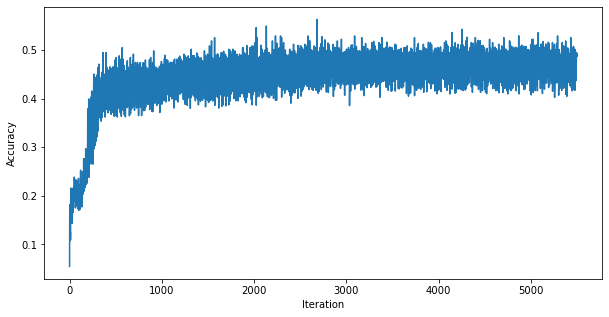

In [17]:
plt.figure(figsize=(10, 5))
plt.ylabel("Accuracy")
plt.xlabel('Iteration')
plt.plot(accs, label='Accuracy vs iteration')
plt.show()

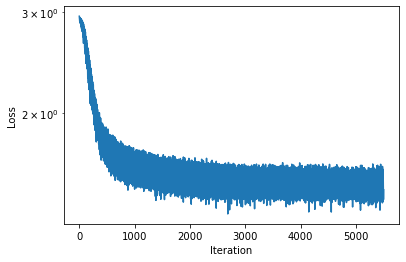

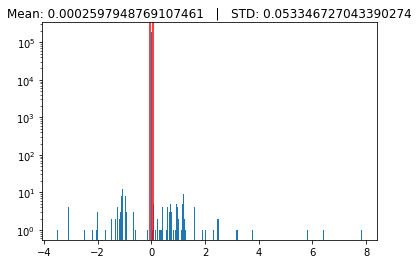

In [18]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.plot(losses, label='Loss vs iteration')
plt.yscale("log")
plt.show()

plt.figure()
weights = tree.inner_nodes.weight.cpu().detach().numpy().flatten()
plt.hist(weights, bins=500)
weights_std = np.std(weights)
weights_mean = np.mean(weights)
plt.axvline(weights_mean + weights_std, color='r')
plt.axvline(weights_mean - weights_std, color='r')
plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
plt.yscale("log")
plt.show()

# Tree Visualization

Average height: 8.330434782608696


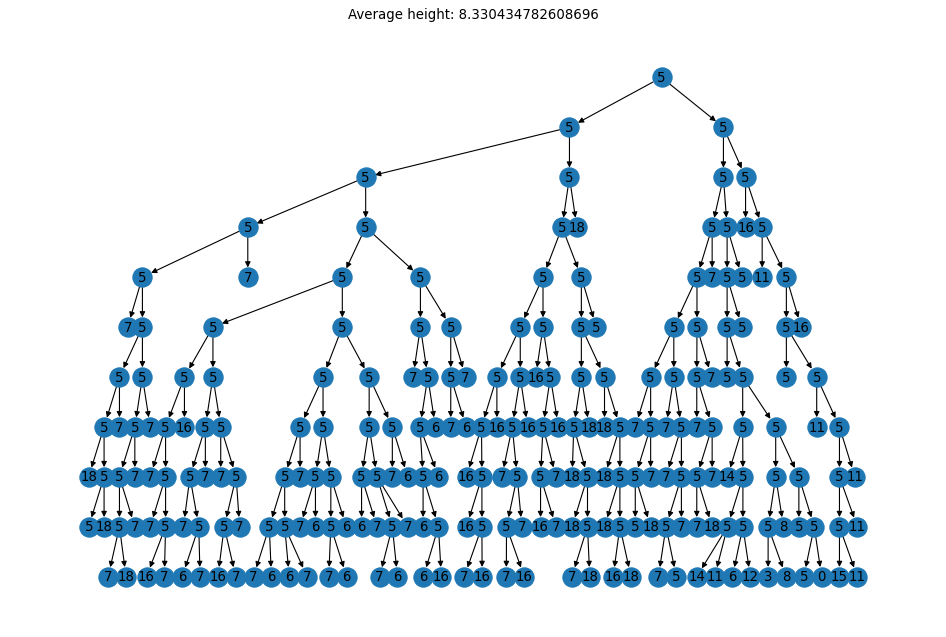

In [19]:
plt.figure(figsize=(15, 10), dpi=80)
avg_height, root = tree.visualize()

# Extract Rules

# Accumulate samples in the leaves

In [20]:
print(f"Number of patterns: {len(root.get_leaves())}")

Number of patterns: 115


In [21]:
method = 'MLE'

In [22]:
root.clear_leaves_samples()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
        root.accumulate_samples(data, method)

/home/eitan.k/miniconda3/envs/rambo/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Tighten boundaries

In [23]:
signal_names = dataset.dataset.all_signals
normalizers = torch.tensor([])
attr_names = []
for signal_name in signal_names:
    attr_names += [f"T{i}.{signal_name}" for i in range(sampled.shape[-1])]
    sensor_norm = torch.tensor([torch.tensor(dataset.dataset.sensor_maxs[signal_name]) for _ in range(sampled.shape[-1])])
    normalizers = torch.cat([normalizers, sensor_norm])
    

# print(attr_names)
leaves = root.get_leaves()
sum_comprehensibility = 0

for pattern_counter, leaf in enumerate(leaves):
    leaf.reset_path()
    leaf.tighten_with_accumulated_samples()
    conds = leaf.get_path_conditions(attr_names)
    for cond in conds:
        cond.weights = cond.weights / normalizers
    print(f"============== Pattern {pattern_counter + 1} ==============")
    sum_comprehensibility += sum([cond.comprehensibility for cond in conds])
    
print(f"Average comprehensibility: {sum_comprehensibility / len(leaves)}")

/home/eitan.k/EntangledExplainableClustering/soft_decision_tree/sdt_model.py:14: RuntimeWarning: divide by zero encountered in log
  return np.log(1 / (1 - x))


============== Pattern 1 ==============
============== Pattern 2 ==============
============== Pattern 3 ==============
============== Pattern 4 ==============
============== Pattern 5 ==============
============== Pattern 6 ==============
============== Pattern 7 ==============
============== Pattern 8 ==============
============== Pattern 9 ==============
============== Pattern 10 ==============
============== Pattern 11 ==============
============== Pattern 12 ==============
============== Pattern 13 ==============
============== Pattern 14 ==============
============== Pattern 15 ==============
============== Pattern 16 ==============
============== Pattern 17 ==============
============== Pattern 18 ==============
============== Pattern 19 ==============
============== Pattern 20 ==============
============== Pattern 21 ==============
============== Pattern 22 ==============
============== Pattern 23 ==============
============== Pattern 24 ==============
============== Pattern 25

In [ ]:
# prune_tree(tree, factor=1.5)
correct = 0
tree = tree.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
            data, target = data.to(device), target.to(device)
            output = tree.forward(data)
            pred = output.data.max(1)[1]
            correct += pred.eq(target.view(-1).data).sum()

print(f"Accuracy: {correct / len(tree_loader.dataset)}")

In [ ]:
print(f"Sparseness: {sparseness(tree.inner_nodes.weight)}")
layer = 0
sps = []
for i in range(tree.inner_nodes.weight.shape[0]):
    cur_layer = np.floor(np.log2(i+1))
    if cur_layer != layer:
        print(f"layer {layer}: {np.mean(sps)}")
        sps = []
        layer = cur_layer
    
    x_ = tree.inner_nodes.weight[i, :]
    sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
    sps.append(sp)

## Prune the weights

In [ ]:
weights = tree.inner_nodes.weight.cpu().detach().numpy()
for i in range(0, weights.shape[0], 20):
    plt.figure()
    weights_layer = weights[i, :]
    plt.hist(weights_layer, bins=500)
    weights_std = np.std(weights_layer)
    weights_mean = np.mean(weights_layer)
    plt.axvline(weights_mean + weights_std, color='r')
    plt.axvline(weights_mean - weights_std, color='r')
    plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}\n Kurtosis: {kurtosis(weights_layer)}")
    plt.yscale("log")
    plt.show()

## Verify that the accuracy didn't change too much

In [ ]:
correct = 0
tree_copy = tree_copy.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
            data, target = data.to(device), target.to(device)
            output = tree_copy.forward(data)
            pred = output.data.max(1)[1]
            correct += pred.eq(target.view(-1).data).sum()

print(f"Accuracy: {correct / len(tree_loader.dataset)}")


In [ ]:
weights = tree_copy.inner_nodes.weight.cpu().detach().numpy()
for i in range(0, weights.shape[0], 20):
    plt.figure()
    weights_layer = weights[i, :]
    plt.hist(weights_layer, bins=500)
    weights_std = np.std(weights_layer)
    weights_mean = np.mean(weights_layer)
    plt.axvline(weights_mean + weights_std, color='r')
    plt.axvline(weights_mean - weights_std, color='r')
    plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
    plt.yscale("log")
    plt.show()

In [ ]:

stack = LifoQueue()
edge_stack = LifoQueue()
stack.put(root)
rule_counter = 0
root.reset()
while not stack.empty():
    node = stack.get()
    if node.is_leaf():
        print(f"============== Rule {rule_counter} ==============")
        for stack_node, cond in zip(stack.queue, edge_stack.queue[1:]):
            print(repr(stack_node.get_condition(attr_names)) + cond)
            print()
        
        rule_counter += 1
        edge_stack.get()
        continue
          
    if node.left is not None and not node.left.visited:
        stack.put(node)
        stack.put(node.left)
        node.left.visited = True
        edge_stack.put(' < 0')
        continue
        
    if node.right is not None and not node.right.visited:
        stack.put(node)
        stack.put(node.right)
        node.right.visited = True
        edge_stack.put(' > 0')
        continue
        
    if node is not root:
        edge_stack.get()